# Cross species mapping of endocrine heterogeneity - alpha and beta cells

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy as sc
import pandas as pd
import seaborn as sns
import xlsxwriter
from matplotlib import rcParams
import gseapy as gp
import itertools
from scipy.stats.stats import pearsonr, spearmanr

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
sc.settings.verbosity = 3
sc.logging.print_header()

## Beta cells

In [22]:
human = sc.read('../data/adata_human_beta.h5ad')

In [23]:
pig = sc.read('../data/adata_beta_pig.h5ad')

In [24]:
mouse = sc.read('../data/mouse_beta.h5ad')

In [ ]:
# load from GEO h5ad-files
# # human
# human_endo = sc.read('../data/human_processed.h5ad')
# del human_endo.raw
# human_endo = human_endo[:, ~human_endo.var.feature_is_filtered].copy()
# human = human_endo[human_endo.obs.louvain_anno_broad=='beta'].copy()

# # pig
# pig_endo = sc.read('../data/pig_processed.h5ad')
# del pig_endo.raw
# pig_endo = pig_endo[:, ~pig_endo.var.feature_is_filtered].copy()
# pig = pig_endo[pig_endo.obs.louvain_anno_broad=='beta'].copy()

In [113]:
conv = pd.read_csv('../BED_mapping_genes.csv')

### Explained variance by mappable genes

In [114]:
conv = conv.loc[[gene in human.var_names for gene in conv['human_symbol']]]
conv = conv.loc[[gene in pig.var_names for gene in conv['pig_symbol']]]
conv = conv.loc[[gene in mouse.var_names for gene in conv['mouse_symbol']]]

In [103]:
df_var = pd.DataFrame(index=['all genes'], columns=['human', 'pig', 'mouse'])

In [71]:
# human
df = np.var(human.to_df(), axis=0)
var_tot = df.sum()
var_sub = df.loc[conv['human_symbol'].tolist()].sum()
print(f'explained variance human - all cells: {var_sub/var_tot}')
df_var.loc['all cells', 'human'] = var_sub/var_tot

explained variance human - all cells: 0.8630590438842773


In [65]:
# pig
df = np.var(pig.to_df(), axis=0)
var_tot = df.sum()
var_sub = df.loc[conv['pig_symbol'].tolist()].sum()
print(f'explained variance pig: {var_sub/var_tot}')
df_var.loc['all cells', 'pig'] = var_sub/var_tot

explained variance pig: 0.9356309175491333


In [66]:
# mouse
df = np.var(mouse.to_df(), axis=0)
var_tot = df.sum()
var_sub = df.loc[conv['mouse_symbol'].tolist()].sum()
print(f'explained variance mouse: {var_sub/var_tot}')
df_var.loc['all cells', 'mouse'] = var_sub/var_tot

explained variance mouse: 0.8816480040550232


In [67]:
df_var

human       pig     mouse
all cells  0.863059  0.935631  0.881648

### Subset data to mappable genes and scaling

In [28]:
human_comb = human[:,conv['human_symbol'].tolist()].copy()

In [29]:
human_comb.var_names

Index(['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3',
       'MT-ND3', 'MT-ND4L', 'MT-ND4',
       ...
       'BACH1', 'FAM83H-AS1', 'FAM53C', 'GTPBP10', 'SUMF1', 'BCAR3', 'SMIM8',
       'PDE10A', 'ST7', 'AHSA2'],
      dtype='object', name='index', length=11385)

In [30]:
pig_comb = pig[:,conv['pig_symbol'].tolist()].copy()
pig_comb.var_names

Index(['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'ND4L',
       'ND4',
       ...
       'BACH1', 'IQANK1', 'FAM53C', 'ENSSSCG00000015305', 'SUMF1', 'BCAR3',
       'SMIM8', 'PDE10A', 'ST7', 'ENSSSCG00000008383'],
      dtype='object', length=11385)

In [31]:
mouse_comb = mouse[:,conv['mouse_symbol'].tolist()].copy()
mouse_comb.var_names

Index(['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3',
       'mt-Nd3', 'mt-Nd4l', 'mt-Nd4',
       ...
       'Bach1', 'K230010J24Rik', 'Fam53c', 'Gtpbp10', 'Sumf1', 'Bcar3',
       'Smim8', 'Pde10a', 'St7', 'Ahsa2'],
      dtype='object', name='index', length=11385)

In [32]:
pig_comb.var_names = human_comb.var_names
mouse_comb.var_names = human_comb.var_names

In [33]:
human_comb_scaled = sc.pp.scale(human_comb, copy=True)
pig_comb_scaled = sc.pp.scale(pig_comb, copy=True)
mouse_comb_scaled = sc.pp.scale(mouse_comb, copy=True)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


### Mapping to human beta cell gene set space

In [39]:
mk_human = pd.read_excel('./output_files/gene_sets_beta.xlsx')
mk_human_map = {}
genes = []
for col in mk_human.columns:
    mk_human_map[col] = [gene for gene in mk_human[col] if gene in conv.human_symbol.tolist()]
    genes = genes + mk_human_map[col]

In [40]:
sc.settings.verbosity=1
for key in mk_human_map.keys():
    sc.tl.score_genes(human_comb, gene_list=[gene for gene in mk_human_map[key] if gene in human_comb.var_names], score_name=f'human_G{key}')
    sc.tl.score_genes(pig_comb, gene_list=[gene for gene in mk_human_map[key] if gene in pig_comb.var_names], score_name=f'human_G{key}')
    sc.tl.score_genes(mouse_comb, gene_list=[gene for gene in mk_human_map[key] if gene in mouse_comb.var_names], score_name=f'human_G{key}')

In [41]:
sc.set_figure_params()

In [42]:
# sorted gene sets
obs_g = ['_'.join(['human',a]) for a in ['G7', 'G8', 'G10', 'G11','G3', 'G17', 'G1', 'G2', 'G5', 'G6', 'G4', 'G12', 'G13', 'G14', 'G18', 'G19', 'G9', 'G16']]

# gene set space adata
human_comb_beta_g = sc.AnnData(human_comb.obs[obs_g])
human_comb_beta_g.obs = human_comb.obs
pig_comb_beta_g = sc.AnnData(pig_comb.obs[obs_g])
pig_comb_beta_g.obs = pig_comb.obs
mouse_comb_beta_g = sc.AnnData(mouse_comb.obs[obs_g])
mouse_comb_beta_g.obs = mouse_comb.obs

In [43]:
# scale gene set activation scores
human_comb_beta_g_scaled = sc.pp.scale(human_comb_beta_g, copy=True)
pig_comb_beta_g_scaled = sc.pp.scale(pig_comb_beta_g, copy=True)
mouse_comb_beta_g_scaled = sc.pp.scale(mouse_comb_beta_g, copy=True)

In [44]:
# compute human manifold in gene set space
sc.pp.pca(human_comb_beta_g_scaled)
sc.pp.neighbors(human_comb_beta_g_scaled)
sc.tl.umap(human_comb_beta_g_scaled)

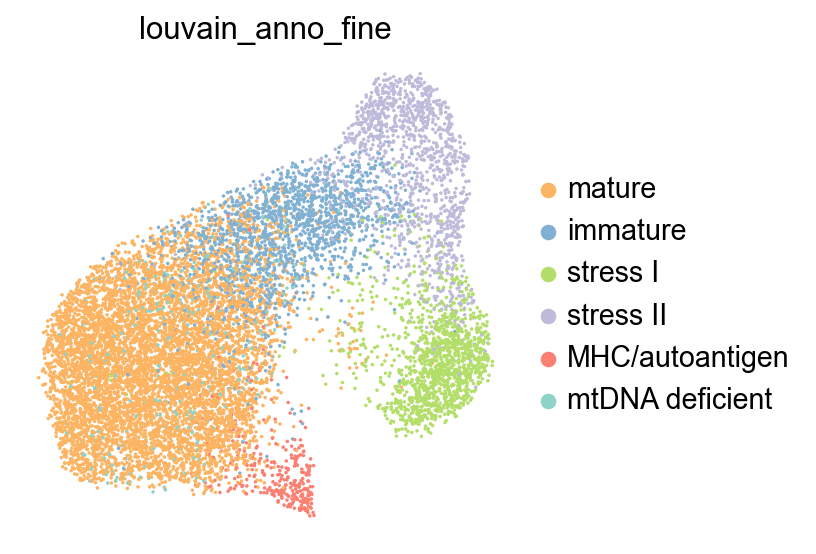

In [45]:
sc.set_figure_params(frameon=False)
# add colors and plot
human_comb_beta_g_scaled.uns['louvain_anno_fine_colors']=['#fdb462', '#80b1d3', '#b3de69', '#bebada', '#fb8072', '#8dd3c7']
sc.pl.umap(human_comb_beta_g_scaled, color='louvain_anno_fine')

In [46]:
# map pig to human embedding and annotate cells
sc.tl.ingest(pig_comb_beta_g_scaled, human_comb_beta_g_scaled , obs='louvain_anno_fine', neighbors_key='neighbors', )

In [47]:
# map mouse to human embedding and annotate cells
sc.tl.ingest(mouse_comb_beta_g_scaled, human_comb_beta_g_scaled , obs='louvain_anno_fine', neighbors_key='neighbors', )

In [48]:
# add colors
pig_comb_beta_g_scaled.uns['louvain_anno_fine_colors'] = human_comb_beta_g_scaled.uns['louvain_anno_fine_colors']
mouse_comb_beta_g_scaled.uns['louvain_anno_fine_colors'] = human_comb_beta_g_scaled.uns['louvain_anno_fine_colors']

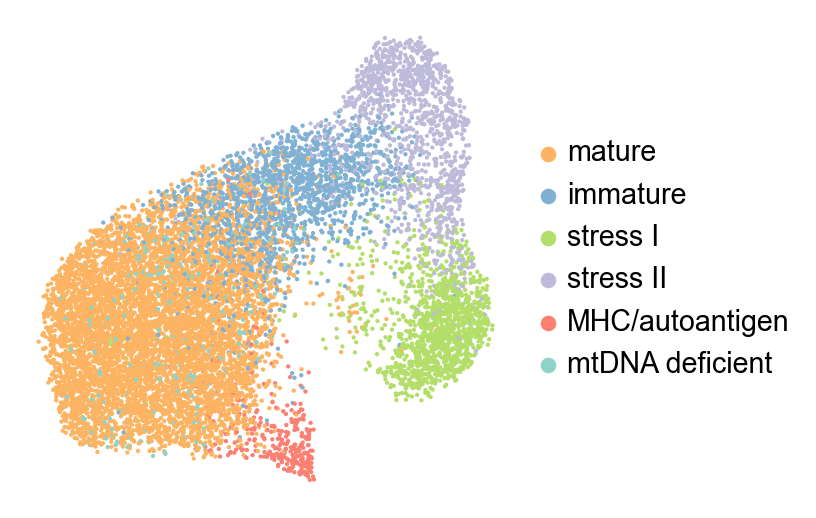

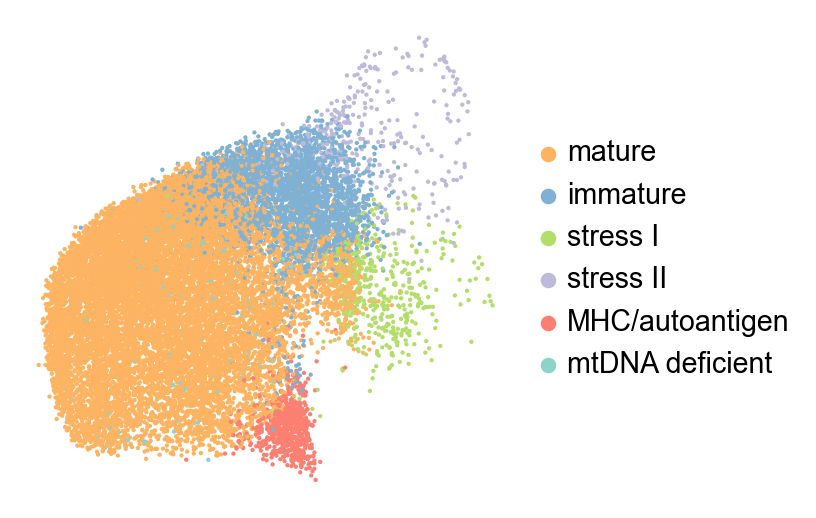

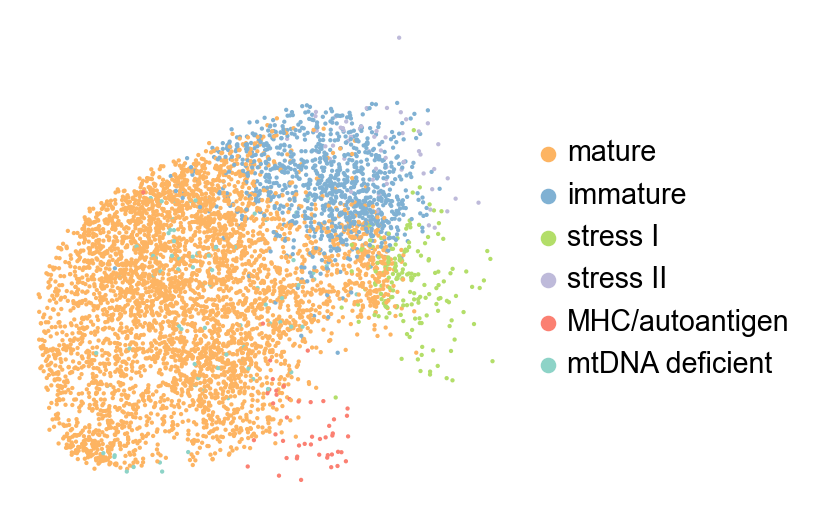

In [49]:
sc.pl.umap(human_comb_beta_g_scaled, color='louvain_anno_fine', size=15, title='')
sc.pl.umap(pig_comb_beta_g_scaled, color=['louvain_anno_fine'], size=15, title='')
sc.pl.umap(mouse_comb_beta_g_scaled, color=['louvain_anno_fine'], size=15, title='')

#### composition

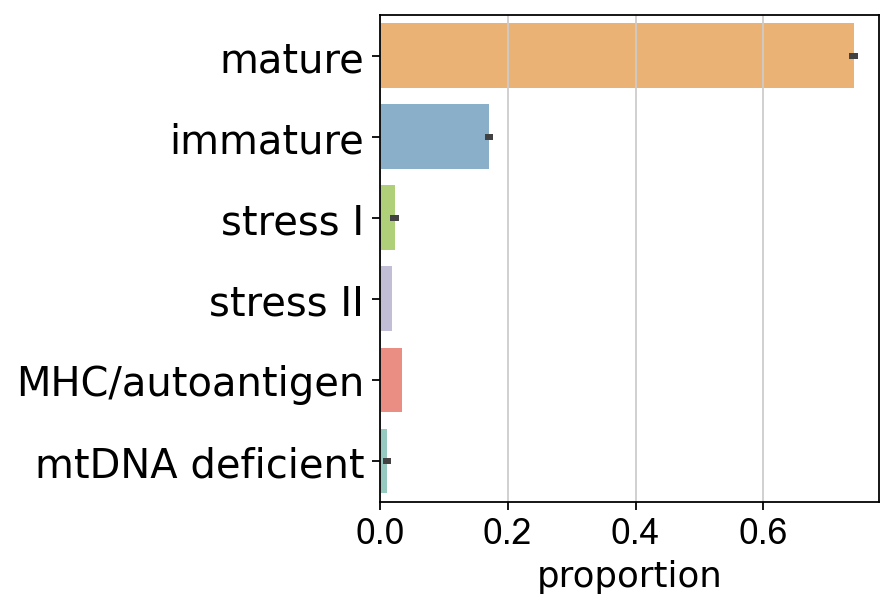

In [63]:
df = pig_comb_beta_g_scaled.obs[['louvain_anno_fine', 'donor']]

pl.subplots()
x = 'louvain_anno_fine'
hue = 'donor'
y = 'proportion'
prop_df = (df[x]
            .groupby(df[hue])
            .value_counts(normalize=True)
            .rename(y)
            .reset_index())

sns.barplot(x=y, y=x, data=prop_df,palette=pig_comb_beta_g_scaled.uns['louvain_anno_fine_colors'],orient='h')
pl.xticks(rotation=0,fontsize=16)
pl.yticks(rotation=0,fontsize=18,fontname='Helvetica Light')
pl.ylabel('')
pl.xlabel('proportion',fontsize=16,fontname='Helvetica Light')
pl.show()

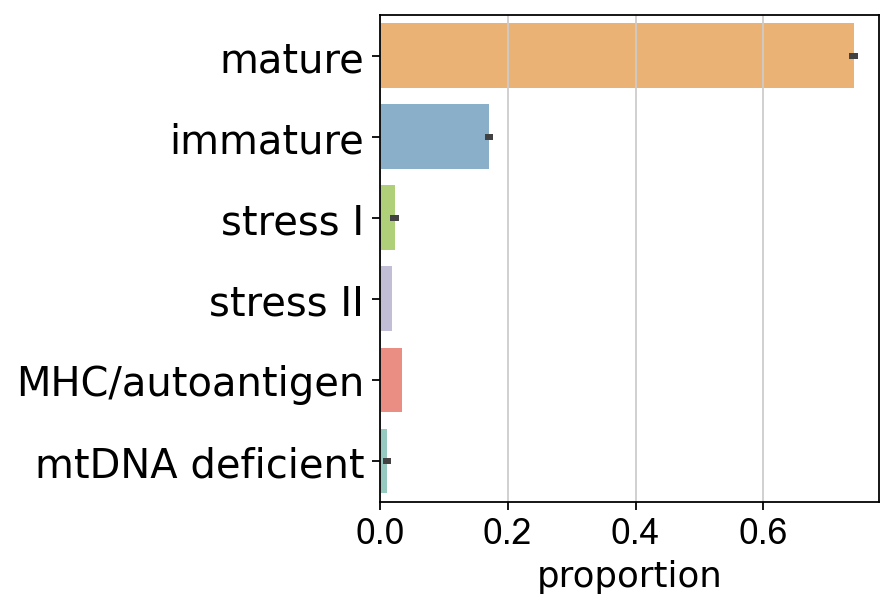

In [52]:
x1='louvain_anno_fine'
hue='donor'
y='proportion'
df = pd.crosstab(pig_comb_beta_g_scaled.obs[x1], pig_comb_beta_g_scaled.obs[hue], normalize=1)
df.index = df.index.tolist()
df.columns = df.columns.tolist()
prop_df = df.reset_index().melt(id_vars=['index'])


pl.subplots()
ax = sns.barplot(y='index', x='value', data=prop_df,palette = pig_comb_beta_g_scaled.uns['louvain_anno_fine_colors'], orient='h')
pl.xticks(rotation=0,fontsize=16)
pl.yticks(rotation=0,fontsize=18,fontname='Helvetica Light')
pl.ylabel('')
pl.xlabel('proportion',fontsize=16,fontname='Helvetica Light')
pl.show()

In [112]:
pig_comb_beta_g_scaled.obs['louvain_anno_fine'].value_counts()

mature             14095
immature            3258
MHC/autoantigen      662
stress I             444
stress II            352
mtDNA deficient      207
Name: louvain_anno_fine, dtype: int64

In [59]:
prop_df[['index', 'value']].groupby('index').mean()

value
index                    
MHC/autoantigen  0.034825
immature         0.171354
mature           0.741065
mtDNA deficient  0.010833
stress I         0.023409
stress II        0.018514

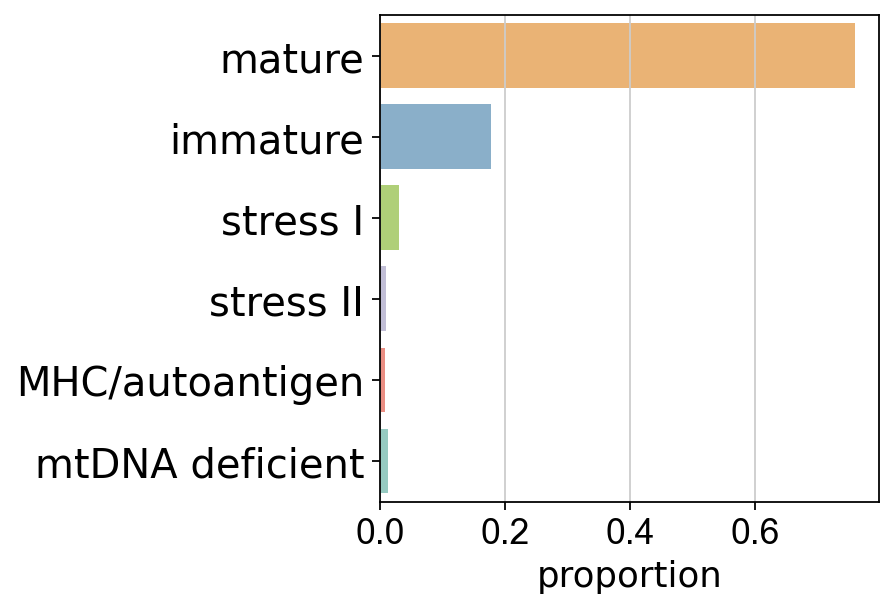

In [174]:
df=mouse_comb_beta_g_scaled.obs[['louvain_anno_fine']]

pl.subplots()
x='louvain_anno_fine'
y='proportion'
prop_df = (df[x]
            .value_counts(normalize=True)
            .rename(y)
            .reset_index())

sns.barplot(x='proportion', y='index', data=prop_df,palette=pig_comb_beta_g_scaled.uns['louvain_anno_fine_colors'],orient='h')
pl.xticks(rotation=0,fontsize=16)
pl.yticks(rotation=0,fontsize=18,fontname='Helvetica Light')
pl.ylabel('')
pl.xlabel('proportion',fontsize=16,fontname='Helvetica Light')
pl.show()

In [175]:
prop_df

index  proportion
0           mature    0.760064
1         immature    0.177260
2         stress I    0.030720
3  mtDNA deficient    0.013595
4        stress II    0.010064
5  MHC/autoantigen    0.008298

In [111]:
mouse_comb_beta_g_scaled.obs['louvain_anno_fine'].value_counts()

mature             4305
immature           1004
stress I            174
mtDNA deficient      77
stress II            57
MHC/autoantigen      47
Name: louvain_anno_fine, dtype: int64

In [173]:
pig_comb_beta_g_scaled.obs['louvain_anno_fine'].value_counts()

mature             14095
immature            3258
MHC/autoantigen      662
stress I             444
stress II            352
mtDNA deficient      207
Name: louvain_anno_fine, dtype: int64

#### gene set activation

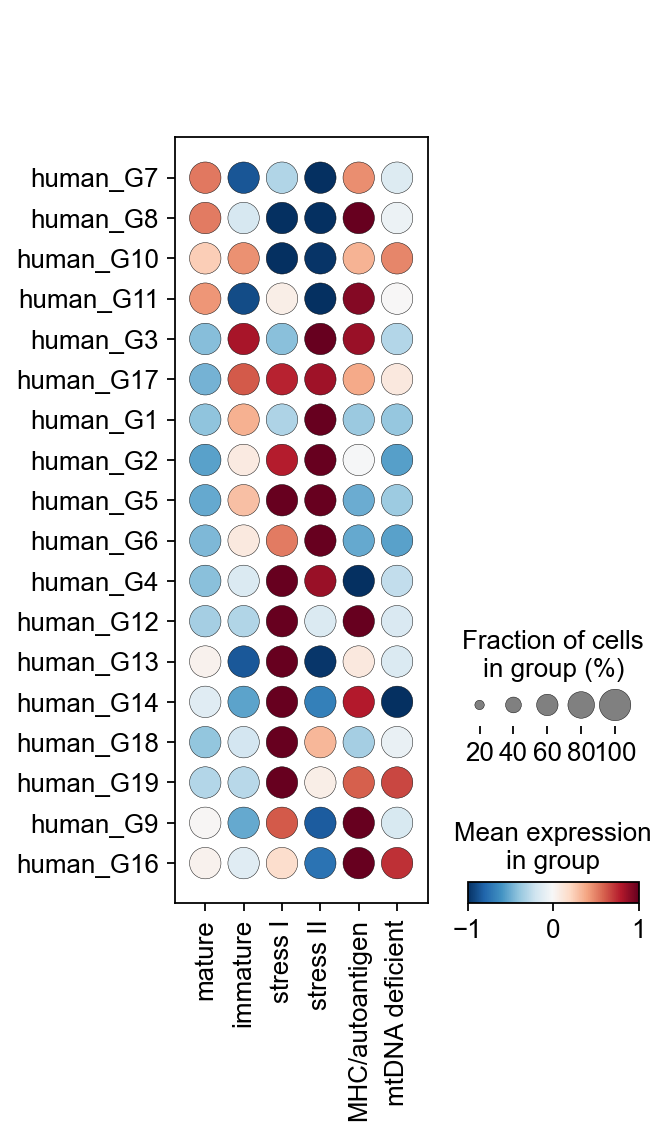

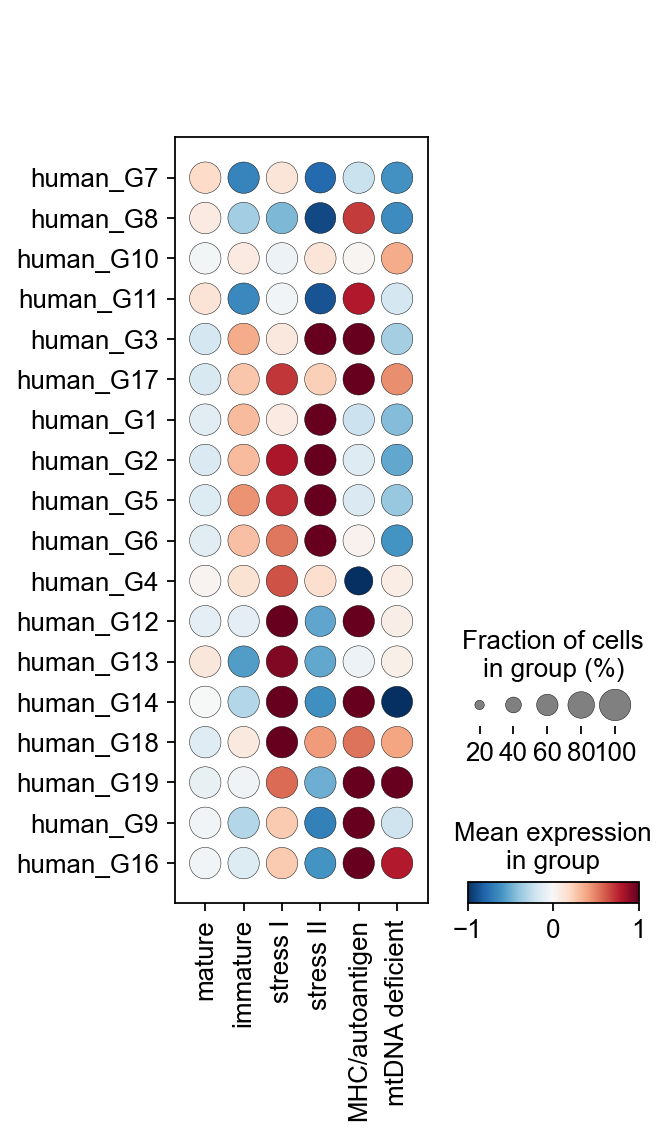

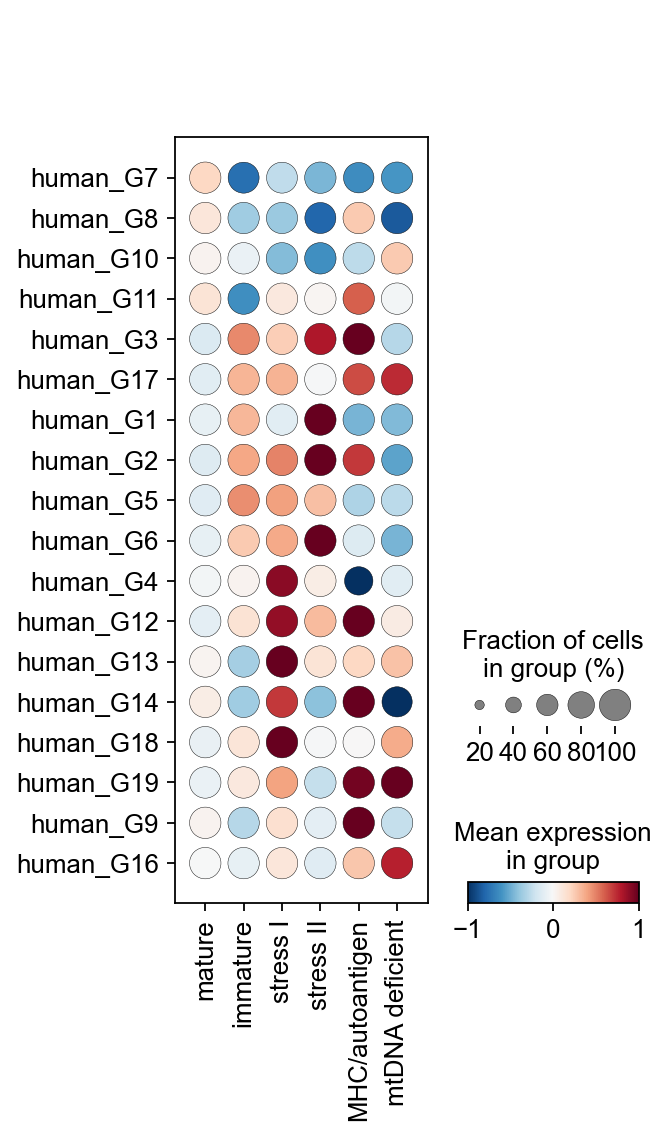

In [46]:
sc.pl.dotplot(human_comb_beta_g_scaled, groupby='louvain_anno_fine', 
              var_names=obs_g, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')
sc.pl.dotplot(pig_comb_beta_g_scaled, groupby='louvain_anno_fine', 
              var_names=obs_g, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')
sc.pl.dotplot(mouse_comb_beta_g_scaled, groupby='louvain_anno_fine', 
              var_names=obs_g, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')

#### marker gene expression

In [126]:
# add mappings to gene expression manifold
pig_comb.obs['louvain_anno_fine'] = pig_comb_beta_g_scaled.obs['louvain_anno_fine']
mouse_comb.obs['louvain_anno_fine'] = mouse_comb_beta_g_scaled.obs['louvain_anno_fine']

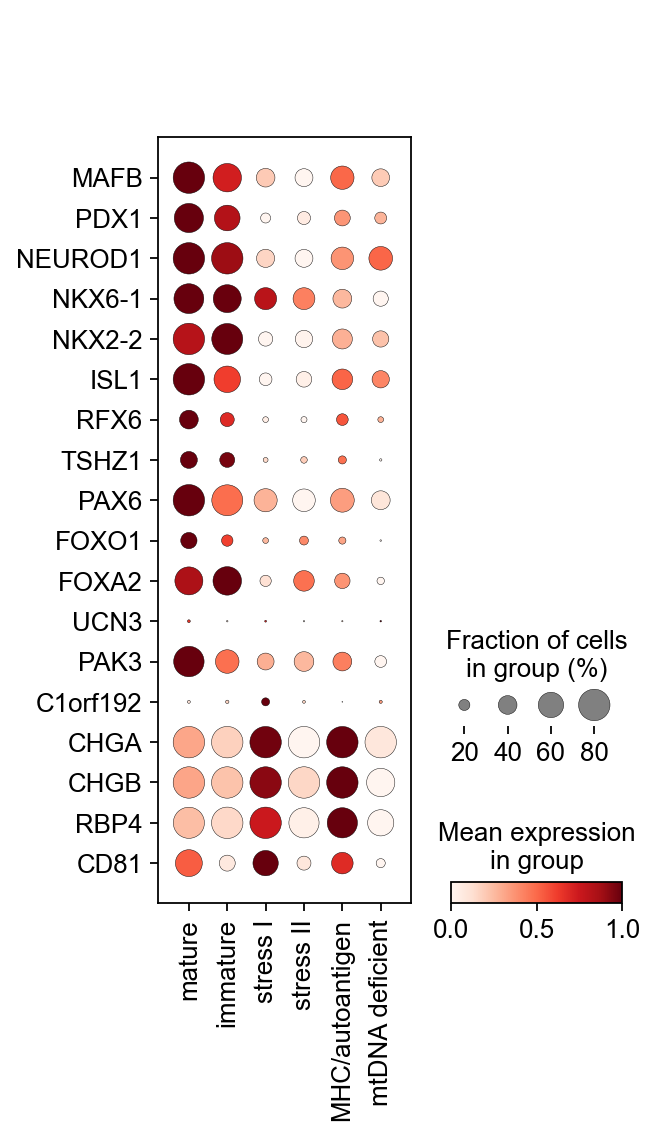

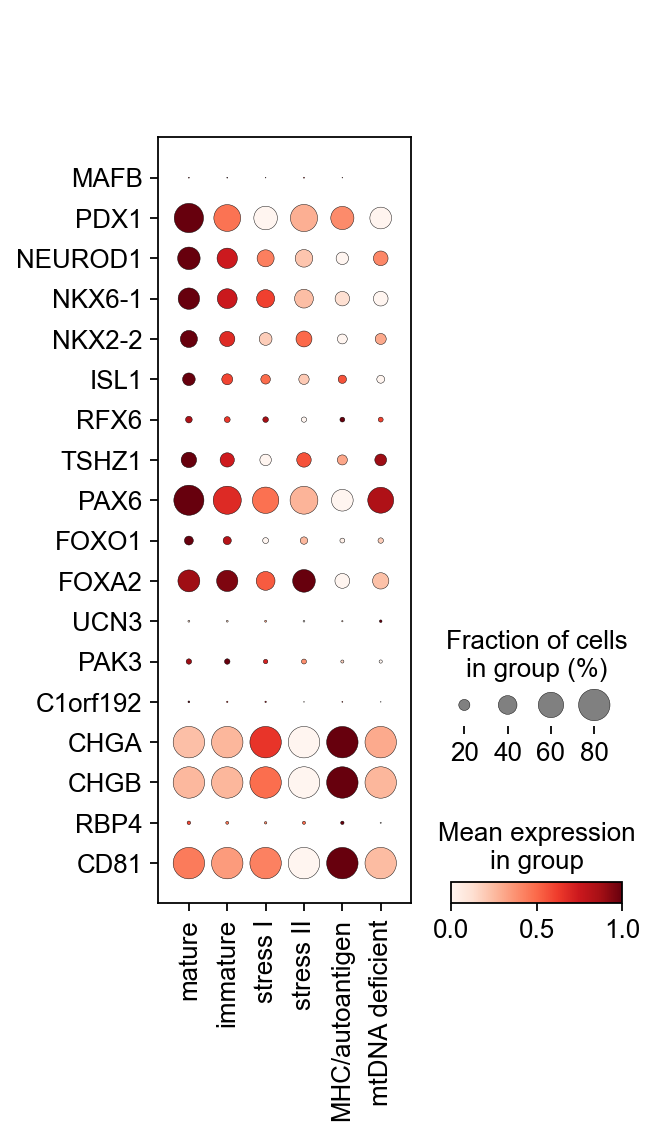

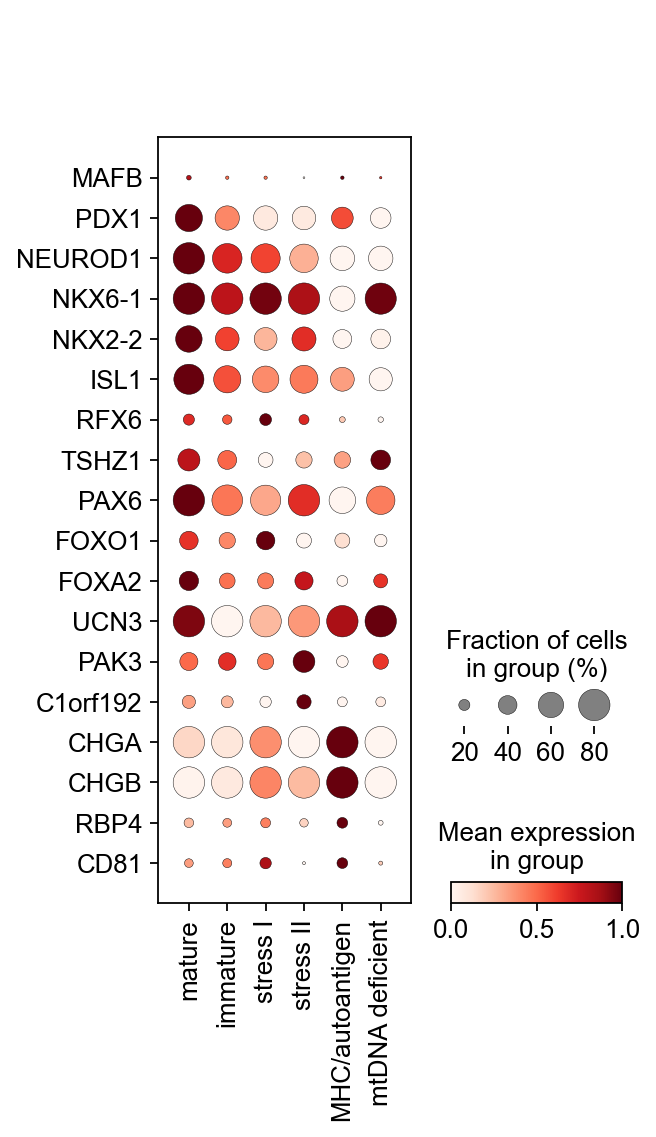

In [240]:
sc.pl.dotplot(human_comb, groupby='louvain_anno_fine',
              var_names=['MAFB', 'PDX1', 'NEUROD1', 'NKX6-1', 'NKX2-2', 'ISL1', 'RFX6', 
                         'TSHZ1', 'PAX6', 'FOXO1', 'FOXA2', 'UCN3', 'PAK3', 'C1orf192',
                         'CHGA', 'CHGB', 'RBP4', 'CD81'],
              standard_scale='var', dot_max=0.8, swap_axes=True)
sc.pl.dotplot(pig_comb, groupby='louvain_anno_fine',
              var_names=['MAFB', 'PDX1', 'NEUROD1', 'NKX6-1', 'NKX2-2', 'ISL1', 'RFX6', 
                         'TSHZ1', 'PAX6', 'FOXO1', 'FOXA2', 'UCN3', 'PAK3', 'C1orf192',
                         'CHGA', 'CHGB', 'RBP4', 'CD81'],
              standard_scale='var', dot_max=0.8, swap_axes=True)
sc.pl.dotplot(mouse_comb, groupby='louvain_anno_fine',
              var_names=['MAFB', 'PDX1', 'NEUROD1', 'NKX6-1', 'NKX2-2', 'ISL1', 'RFX6', 
                         'TSHZ1', 'PAX6', 'FOXO1', 'FOXA2', 'UCN3', 'PAK3', 'C1orf192',
                         'CHGA', 'CHGB', 'RBP4', 'CD81'],
              standard_scale='var', dot_max=0.8, swap_axes=True)

### Correlation of beta cell subtypes in PC space

In [55]:
adata_comb_beta = sc.pp.scale(human_comb, copy=True).concatenate(sc.pp.scale(pig_comb, copy=True), sc.pp.scale(mouse_comb, copy=True), batch_categories=['human', 'pig', 'mouse'])

In [64]:
sc.pp.highly_variable_genes(adata_comb_beta, n_top_genes=4000, flavor='cell_ranger')
sc.pp.pca(adata_comb_beta)

In [65]:
adata_comb_beta.obs['louvain_species'] = ['_'.join([a,b]) for a,b in zip(adata_comb_beta.obs.batch, adata_comb_beta.obs.louvain_anno_fine)]

In [115]:
%%time
genedf = sc.get.obs_df(
        adata_comb_beta,
        keys=['louvain_species'],
        obsm_keys=[('X_pca', i) for i in range(0,50)]
    )
grouped = genedf.groupby('louvain_species')
mean_df = grouped.mean()

CPU times: user 48 ms, sys: 43.7 ms, total: 91.7 ms
Wall time: 132 ms


In [119]:
df_corr = mean_df.T.corr(method='pearson')

#### Clustering and heatmap 

In [120]:
human_comb.uns['louvain_anno_fine_colors']

array(['#fdb462', '#80b1d3', '#b3de69', '#bebada', '#fb8072', '#8dd3c7'],
      dtype=object)

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Use the colorbar set_ticks() method instead.
/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Use the colorbar set_ticks() method instead.


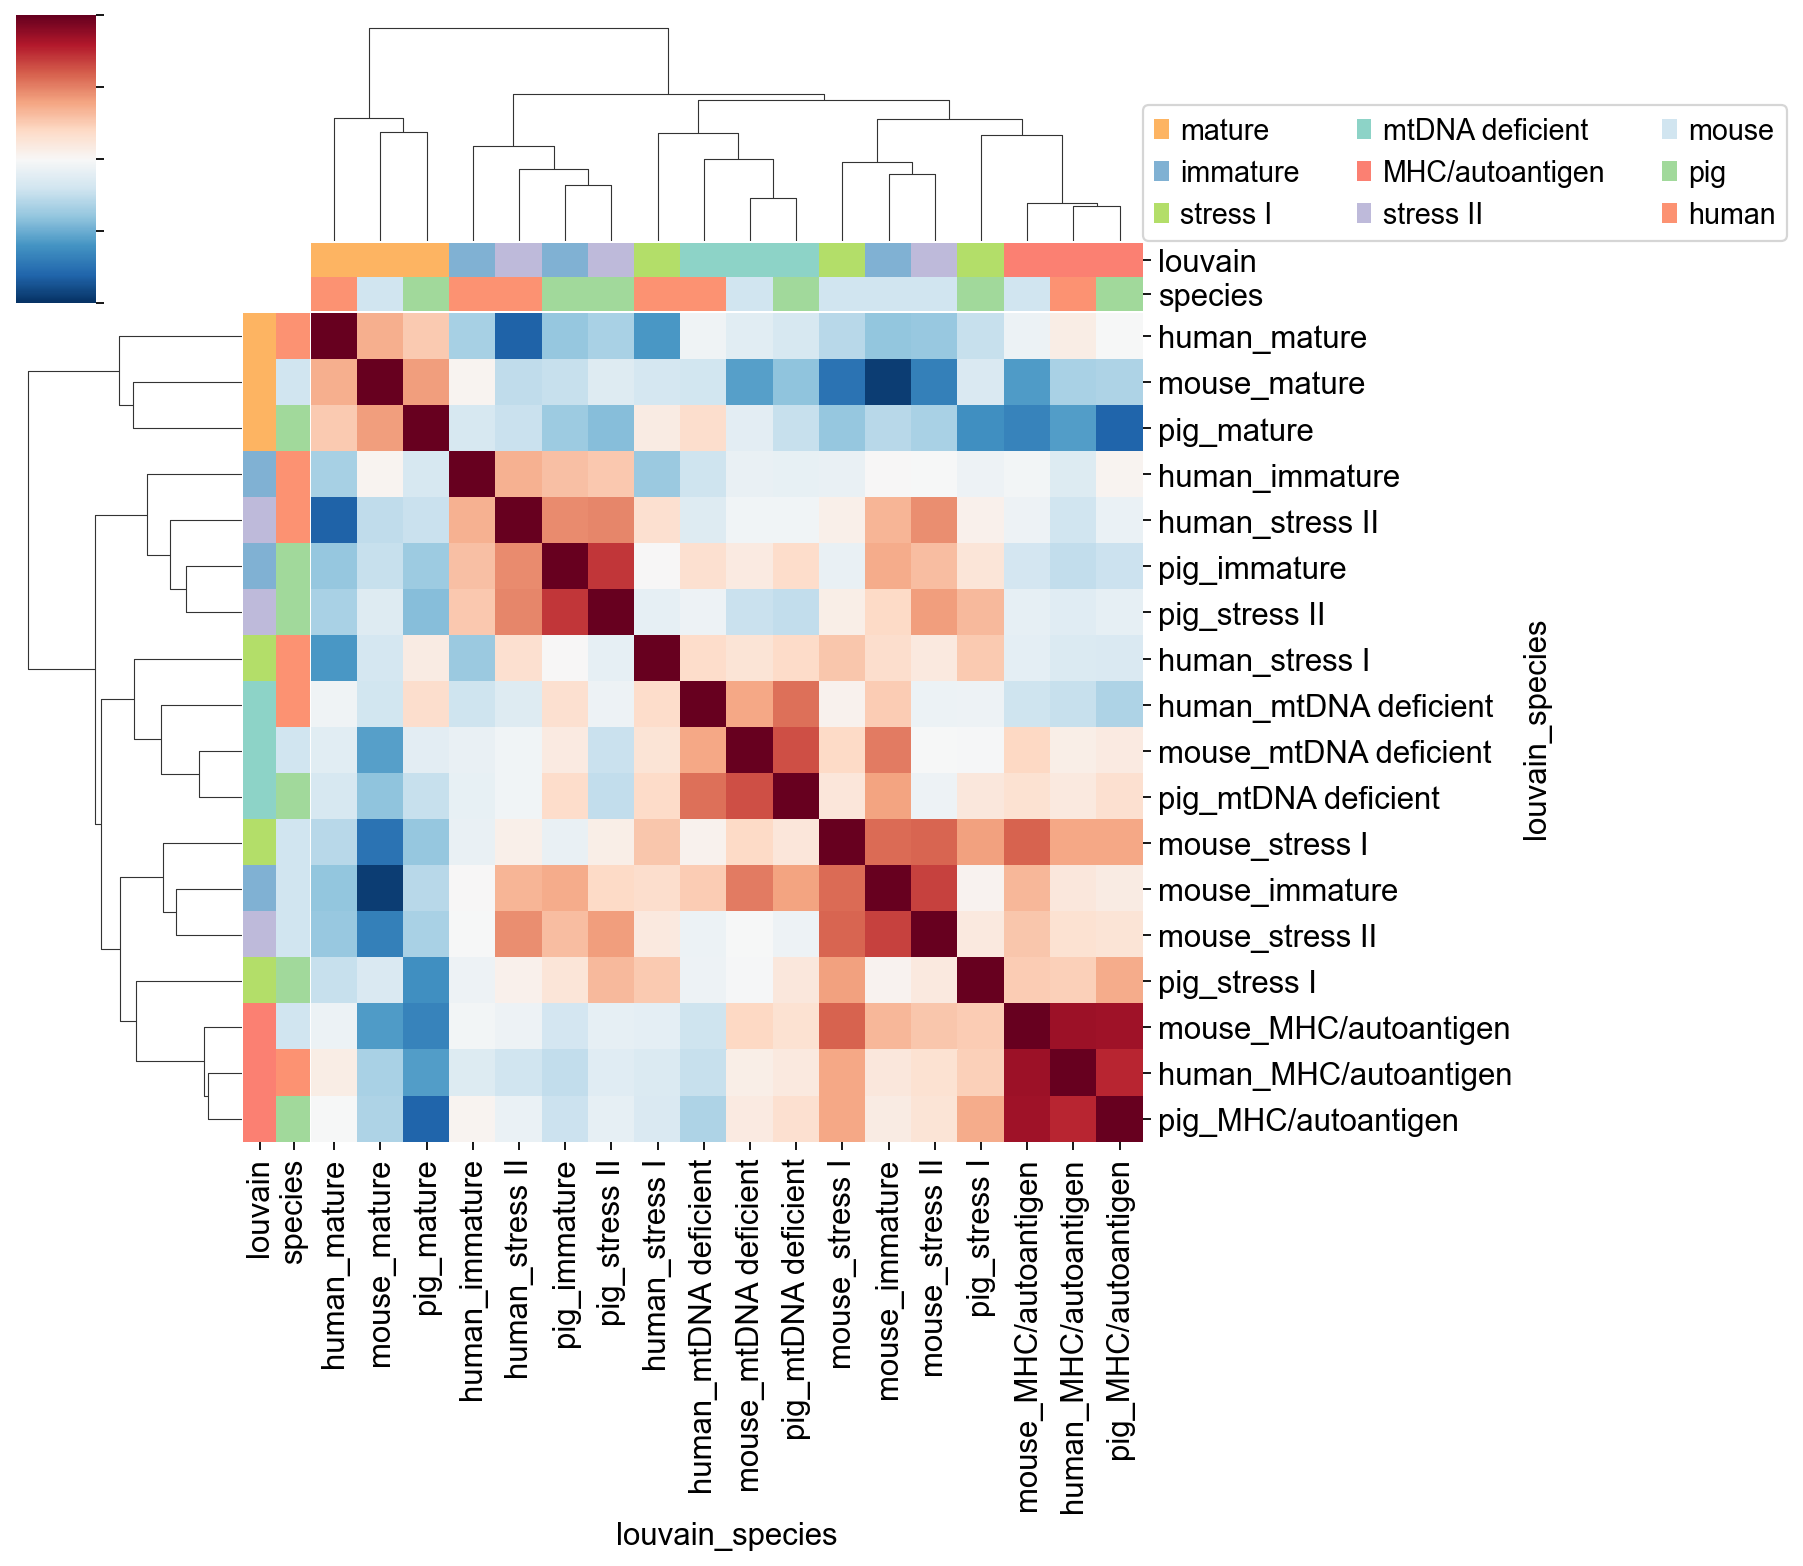

In [121]:
cols = pd.DataFrame(index = df_corr.index)
col_dict_1 = dict(zip(set(adata_comb_beta.obs.louvain_anno_fine.cat.categories), ['#fdb462', '#80b1d3', '#b3de69', '#8dd3c7',  '#fb8072','#bebada']))
cols['louvain'] = pd.DataFrame([g.split('_',1)[1] for g in mean_df.index], index=df_corr.index)[0].map(col_dict_1)
col_dict_2 = dict(zip(set(adata_comb_beta.obs.batch.cat.categories), ['#d1e5f0', '#a1d99b', '#fc9272' ]))
cols['species'] = pd.DataFrame([g.split('_')[0] for g in mean_df.index], index=df_corr.index)[0].map(col_dict_2)

g = sns.clustermap(df_corr,
               col_colors=cols,row_colors=cols, vmin=-1,vmax=1,
               cmap='RdBu_r')

for label in col_dict_1.keys():
    g.ax_col_dendrogram.bar(0, 0, color=col_dict_1[label],
                           label=label, linewidth=0)
for label in col_dict_2.keys():
    g.ax_col_dendrogram.bar(0, 0, color=col_dict_2[label],
                            label=label, linewidth=0)
    
g.cax.set_xticklabels([])
g.cax.set_yticklabels([])
g.cax.set_xticks([])
g.cax.set_yticks([])


g.ax_col_dendrogram.legend(loc=(1,0), ncol=3)

#### Graph representation

In [ ]:
# use paga functionality for plotting correlations
sc.pp.neighbors(adata_comb_beta)
sc.tl.paga(adata_comb_beta, groups='louvain_species')

In [194]:
adata_comb_beta.uns['paga']['connectivities'] = csr_matrix(df_corr.to_numpy().copy())

In [356]:
adata_comb_beta.uns['paga']['connectivities_low_thr'] = csr_matrix(df_corr.to_numpy()+0.1)

In [349]:
pos = np.array([[ 1.62191405,  1.52937668],
       [ 1.23332803,  1.009166 ],
       [ 0.07928282,  1.48927375],
       [-0.2287415, -2.88148255],
       [- 0.24961311, -0.50232758],
       [-1.0590353, -2.26346964],
       [-2.62506038, -1.43752191],
       [-2.58476716, -0.2336543 ],
       [-3.2529614 , -0.68265099],
       [ 3.34791657, -1.03029484],
       [ 2.51190543, -0.50126031],
       [ 2.51983171, -1.55057058],
       [ 0.85409415, -2.26346964],
       [-1.745026  , -0.93045428],
       [-0.0287415 , -1.63648541],
       [-0.24350365,  0.58598068],
       [-1.47740348,  0.02772971],
       [ 1.24261767,  0.02772971]])

In [350]:
human_comb_beta_g_scaled.uns['louvain_anno_fine_colors']

['#fdb462', '#80b1d3', '#b3de69', '#bebada', '#fb8072', '#8dd3c7']

In [351]:
adata_comb_beta.uns['louvain_species_colors'] = ['#fb8072','#fb8072','#fb8072',
                                                 '#80b1d3','#80b1d3','#80b1d3',
                                                 '#fdb462','#fdb462','#fdb462',
                                                 '#8dd3c7','#8dd3c7','#8dd3c7',
                                                 '#bebada','#bebada','#bebada',
                                                 '#b3de69','#b3de69','#b3de69']

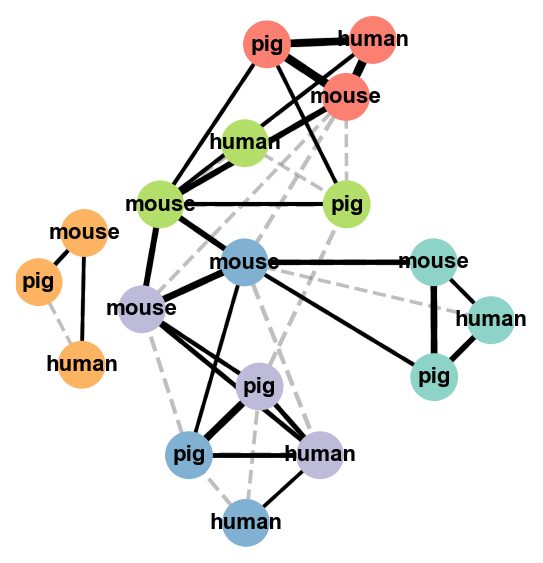

In [357]:
sc.pl.paga(adata_comb_beta, threshold=0.35, edge_width_scale=0.6, fontsize=10, dashed_edges='connectivities_low_thr',
           pos = pos, node_size_power=0, node_size_scale=3,
           labels=['human', 'mouse', 'pig', 'human', 'mouse', 'pig', 
                   'human', 'mouse', 'pig', 'human', 'mouse', 'pig', 
                   'human', 'mouse', 'pig', 'human', 'mouse', 'pig'])

### Conservation of gene sets

In [115]:
mk_human = pd.read_excel('./output_files/gene_sets_beta.xlsx')
gene_sets_map = {}
for col in mk_human.columns:
    gene_sets_map[f'G{col}'] = [gene for gene in mk_human[col] if gene in conv.human_symbol.tolist()]

In [116]:
gs_dict = {'mature': ['G7', 'G8', 'G10', 'G11'],
           'immature': ['G3', 'G17'],
           'stress II': ['G1', 'G2', 'G5', 'G6'],
           'stress I': ['G4', 'G12', 'G13', 'G14', 'G18', 'G19'],
           'MHC/autoantigen': ['G9', 'G16']}

In [117]:
gene_sets_louvain = {}
for key in gs_dict.keys():
    genes = []
    for gs in gs_dict[key]:
        genes = genes + gene_sets_map[gs]
        
    gene_sets_louvain[key] = genes

In [118]:
tfs = pd.read_csv('./data/TF_names_v_1.01_human.txt',sep='\t',header=None).unstack().tolist()

In [119]:
gene_sets_tf = {}
for key in gene_sets_map.keys():
    gene_sets_tf[key] = [tf for tf in gene_sets_map[key] if tf in tfs]

In [120]:
gene_sets_tf_louvain = {}

for key in gs_dict.keys():
    tfs = []
    for gs in gs_dict[key]:
        tfs = tfs + gene_sets_tf[gs]
        
    gene_sets_tf_louvain[key]=tfs

In [121]:
human_comb.obs['human_louvain_anno_fine'] = human_comb.obs['louvain_anno_fine']

In [127]:
expression_dict_beta_species={}

df = pd.DataFrame(index=human_comb.var_names, columns=human_comb.obs.louvain_anno_fine.cat.categories)
for key in human_comb.obs.louvain_anno_fine.cat.categories:
    human_sub = human_comb[human_comb.obs.louvain_anno_fine.isin([key])].copy()
    genes = (human_sub.X > 0).sum(0) / human_sub.n_obs
    df[key] = genes.A1
expression_dict_beta_species['human'] = df

df = pd.DataFrame(index=pig_comb.var_names, columns=pig_comb.obs.louvain_anno_fine.cat.categories)
for key in pig_comb.obs.louvain_anno_fine.cat.categories:
    pig_sub = pig_comb[pig_comb.obs.louvain_anno_fine.isin([key])].copy()
    genes = (pig_sub.X > 0).sum(0) / pig_sub.n_obs
    df[key] = genes.A1
expression_dict_beta_species['pig'] = df 

df = pd.DataFrame(index=mouse_comb.var_names, columns=mouse_comb.obs.louvain_anno_fine.cat.categories)
for key in mouse_comb.obs.louvain_anno_fine.cat.categories:
    mouse_sub = mouse_comb[mouse_comb.obs.louvain_anno_fine.isin([key])].copy()
    genes = (mouse_sub.X > 0).sum(0) / mouse_sub.n_obs
    df[key] = genes.A1
expression_dict_beta_species['mouse'] = df

In [128]:
tfs_mapped = [tf for tf in tfs if tf in human_comb.var_names]

In [129]:
gene_set_conservation_dict = {}

for key in ['mature', 'immature', 'stress I', 'stress II', 'MHC/autoantigen']:

    genes_human = gene_sets_louvain[key]
    df = pd.DataFrame(index=genes_human, columns=['mouse', 'pig'])  
    
    
    detected = expression_dict_beta_species['pig']>0.05
    detected = detected.index[detected.any(axis=1)].tolist()
    
    detected_key = expression_dict_beta_species['pig']>0.05
    detected_key = detected_key.index[detected_key[key]].tolist()
    
    df['pig'] = ['conserved' if gene in detected_key else
                 'loss' if gene in detected else
                 'not detected' for gene in genes_human]
    
    detected = expression_dict_beta_species['mouse']>0.05
    detected = detected.index[detected.any(axis=1)].tolist()
    
    detected_key = expression_dict_beta_species['mouse']>0.05
    detected_key = detected_key.index[detected_key[key]].tolist()
    
    df['mouse'] = ['conserved' if gene in detected_key else
                   'loss' if gene in detected else
                   'not detected' for gene in genes_human]
    
    gene_set_conservation_dict[key]=df


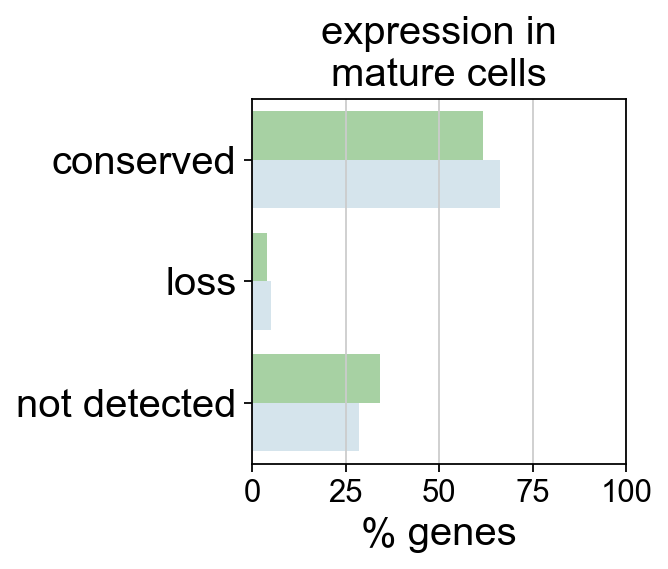

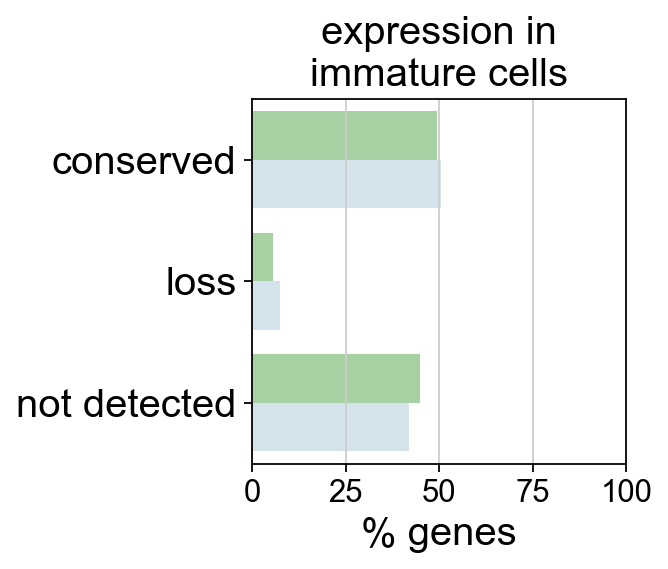

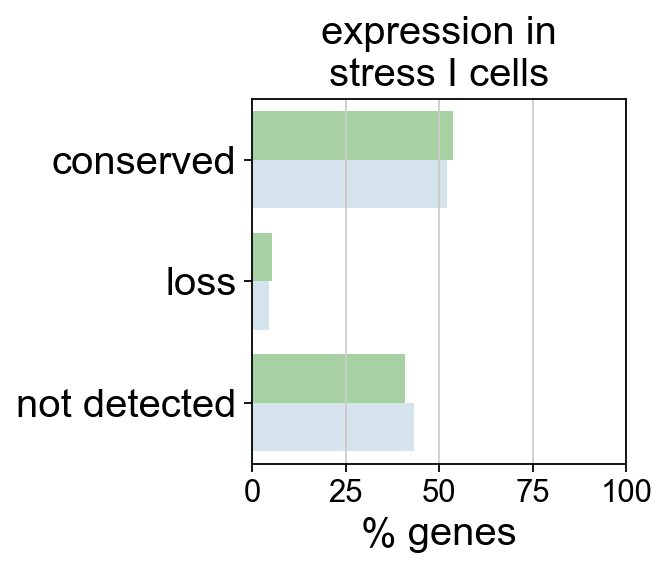

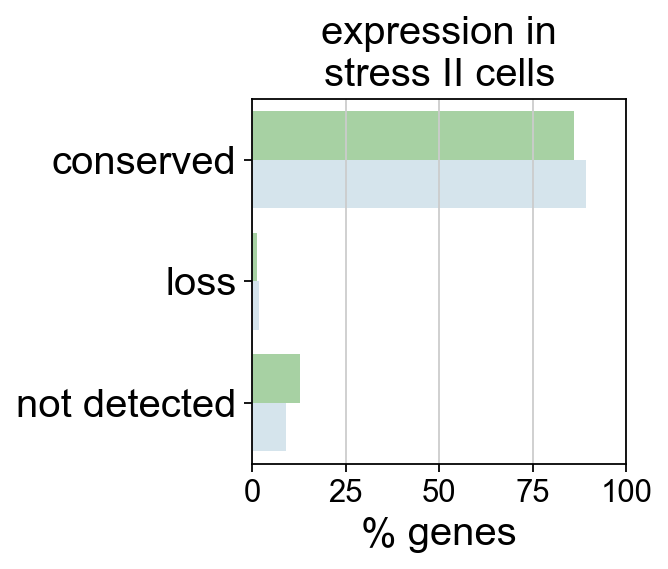

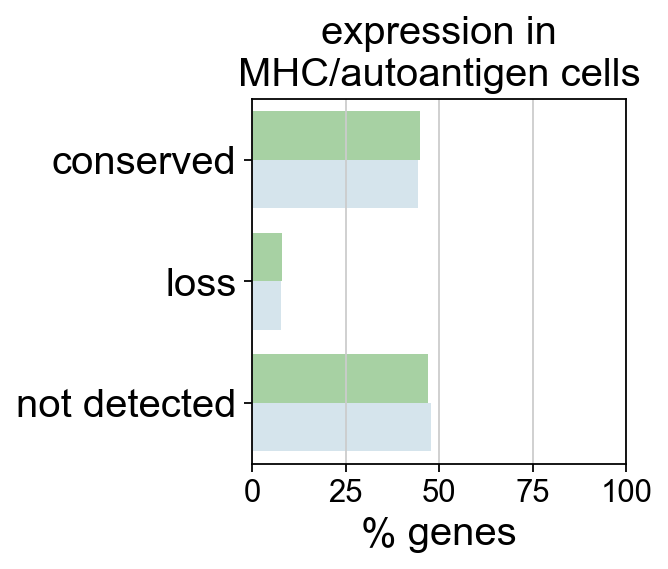

In [70]:
for key in ['mature', 'immature', 'stress I', 'stress II', 'MHC/autoantigen']:
    df_bar = gene_set_conservation_dict[key][['pig', 'mouse']].melt()

    f, ax = pl.subplots(figsize=(3, 3))
    y='% genes'
    prop_df = (df_bar['value']
                        .groupby(df_bar['variable'])
                        .value_counts(normalize=True)
                        .rename(y)
                        .reset_index())
    prop_df[y] = prop_df[y]*100

    sns.barplot(x=y, y="value", data=prop_df, hue='variable', order=['conserved', 'loss', 'not detected'], hue_order=['pig', 'mouse'], palette=['#a1d99b','#d1e5f0'])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    #ax.set_xticklabels([0,20,40,60,80], fontsize=18)
    ax.legend().remove()
    pl.ylabel('')
    pl.xlabel('% genes', fontsize=18)
    pl.xlim([0,100])
    pl.title(f'expression in\n{key} cells', fontsize=18)

### Expression of selected genes

In [302]:
# load pig data
pig_beta_all = sc.read('../data/pig_processed.h5ad')
del pig_beta_all.raw
pig_beta_all = pig_beta_all[:, ~pig_beta_all.var.feature_is_filtered].copy()
pig_beta_all = pig_beta_all[pig_beta_all.obs.louvain_anno_broad=='beta'].copy()
pig_beta_all.var_names = ['WNT4' if var in ['ENSSSCG00000003521'] else var for var in pig_all.var_names]

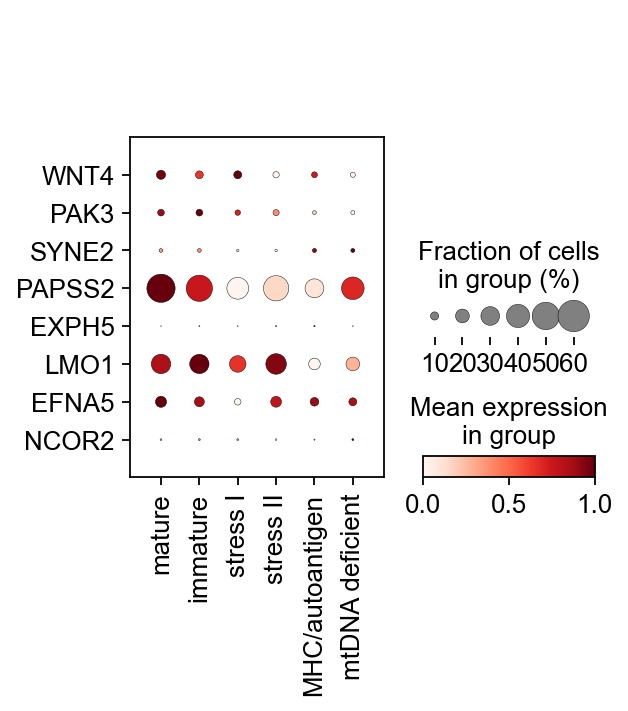

In [305]:
sc.pl.dotplot(pig_beta_all, groupby='louvain_anno_fine',
              var_names=['WNT4', 'PAK3', 'SYNE2', 'PAPSS2', 'EXPH5', 'LMO1', 'EFNA5', 'NCOR2'],
              standard_scale='var', dot_max=0.6, swap_axes=True) #'MAFA', 'MNX1','WNT4', 'BMP5', 'C1orf192',

In [296]:
mouse_beta_all = sc.read('../mouse_islets/data/mouse_beta.h5ad')
mouse_all = sc.read('../mouse_islets/data/mouse_all.h5ad')

In [297]:
mouse_beta_all.obs['louvain_anno_fine'] = mouse_comb_beta_g_scaled.obs['louvain_anno_fine']
mouse_beta_all.obsm['X_umap'] = mouse_comb_beta_g_scaled.obsm['X_umap']

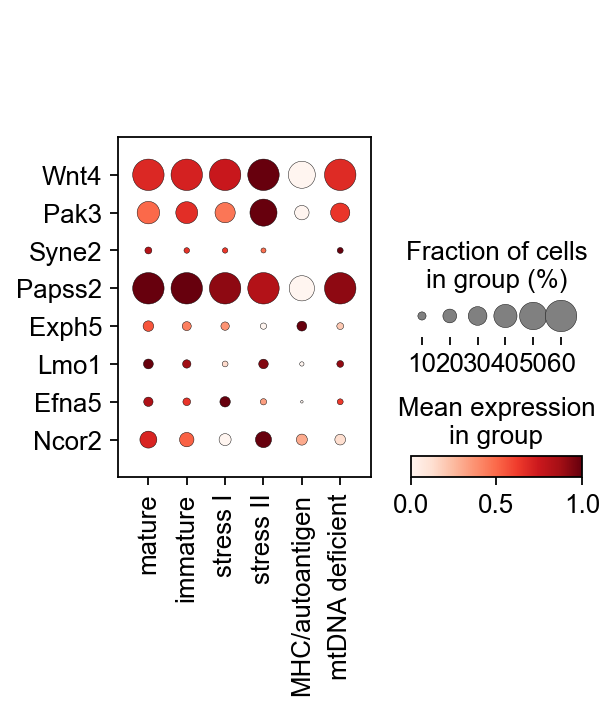

In [298]:
genes=['Wnt4', 'Pak3', 'Syne2', 'Papss2', 'Exph5', 'Lmo1', 'Efna5', 'Ncor2']
sc.pl.dotplot(mouse_beta_all, groupby='louvain_anno_fine', var_names=genes, standard_scale='var', dot_max=0.6, swap_axes=True)

In [299]:
# load human data
human_beta_all = sc.read('../data/human_processed.h5ad')
del human_beta_all.raw
human_beta_all = human_beta_all[:, ~human_beta_all.var.feature_is_filtered].copy()
human_beta_all = human_beta_all[human_beta_all.obs.louvain_anno_broad=='beta'].copy()

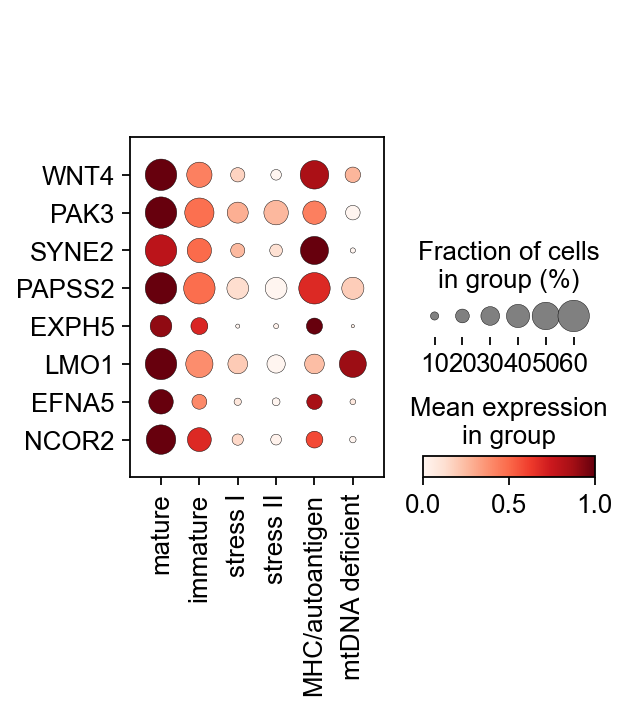

In [301]:
genes=['WNT4', 'PAK3', 'SYNE2', 'PAPSS2', 'EXPH5', 'LMO1', 'EFNA5', 'NCOR2']
sc.pl.dotplot(human_beta_all, groupby='louvain_anno_fine', var_names=genes, standard_scale='var', dot_max=0.6, swap_axes=True)

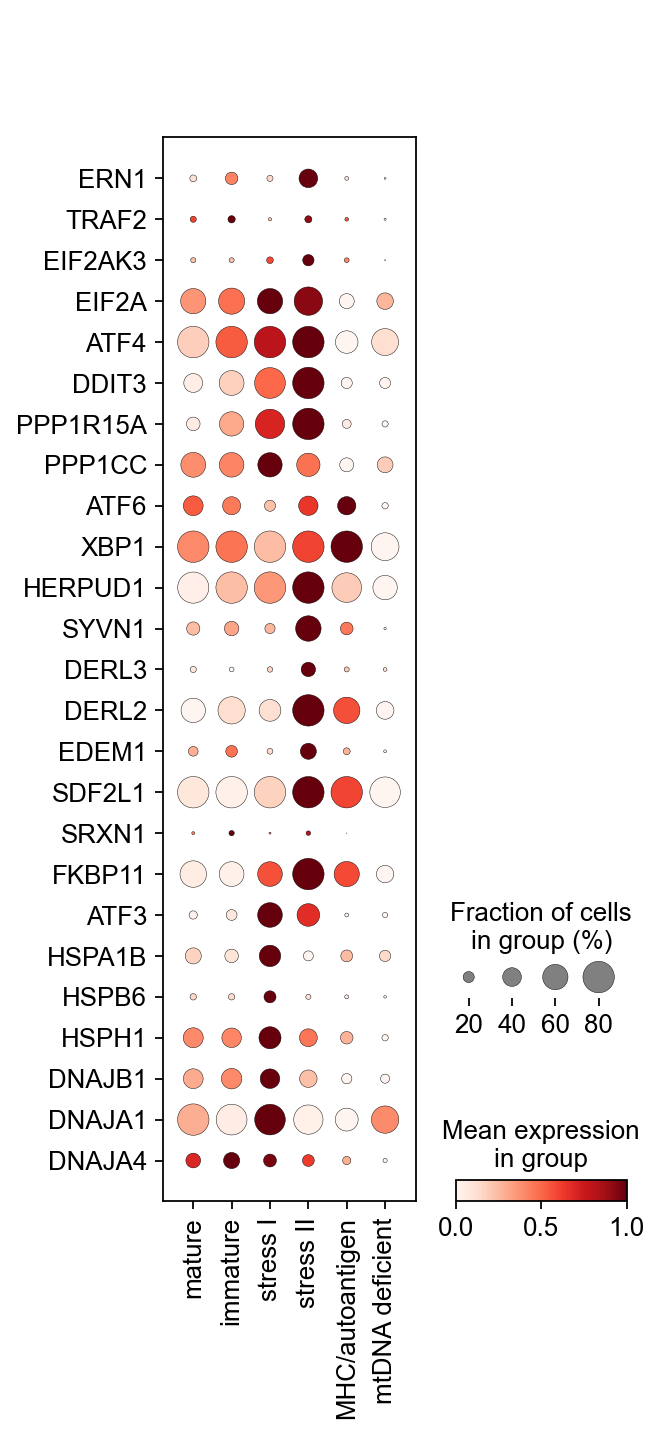

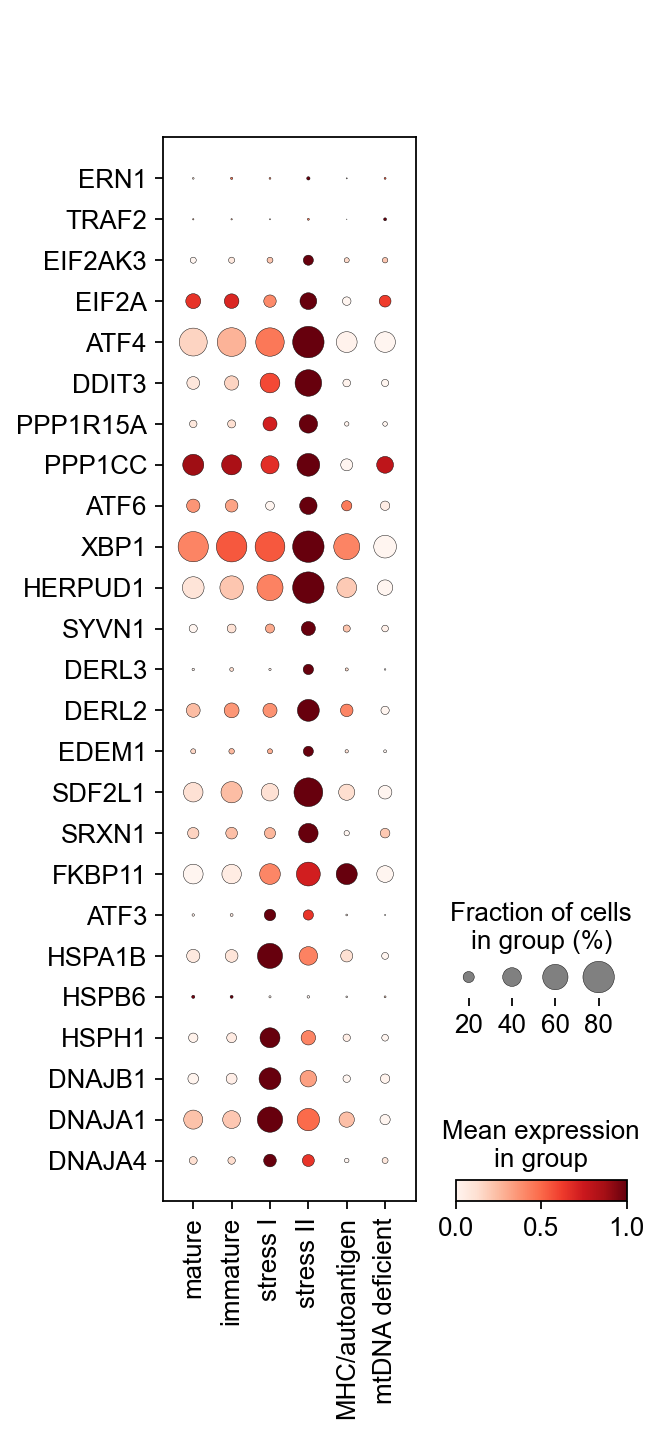

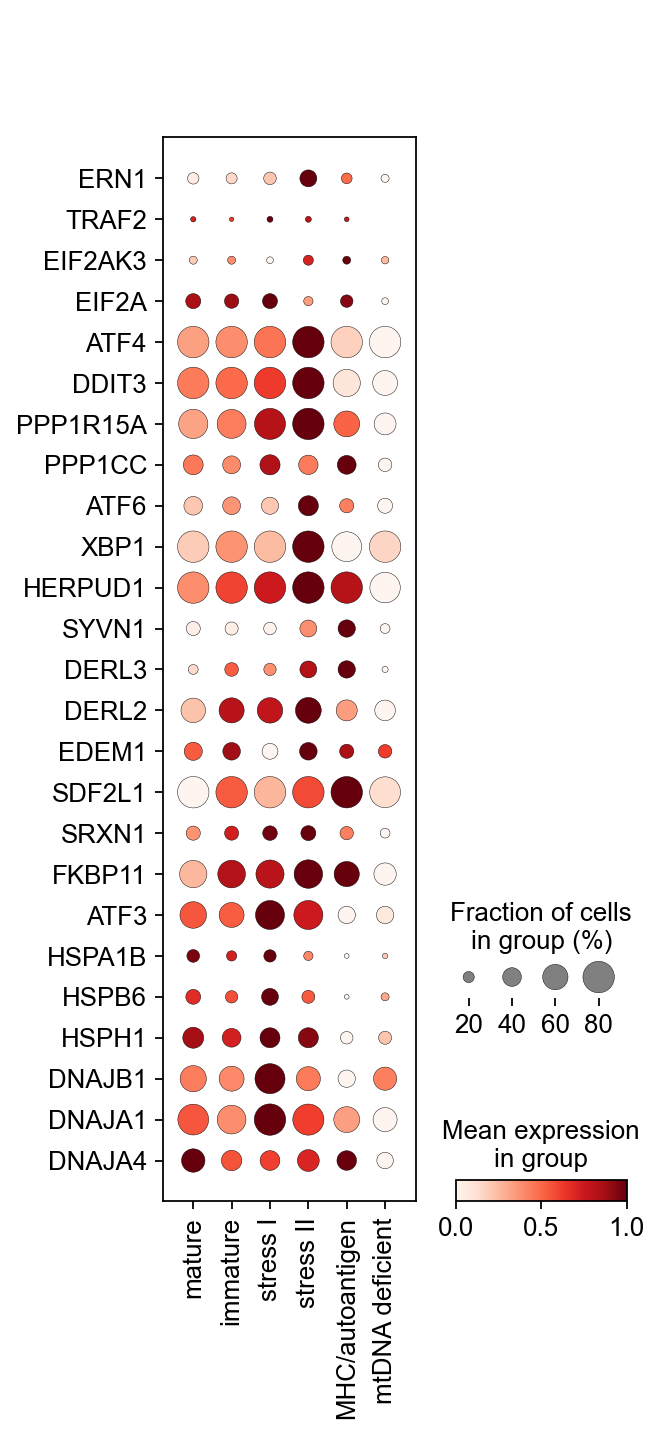

In [379]:
stress_genes = ['ERN1', 'TRAF2', 'EIF2AK3', 'EIF2A', 'ATF4', 'DDIT3', 'PPP1R15A', 'PPP1CC', 'ATF6', 'XBP1', 
                'HERPUD1', 'SYVN1', 'DERL3', 'DERL2', 'EDEM1', 'SDF2L1', 'SRXN1', 'FKBP11', 'ATF3', 'HSPA1B', 
                'HSPB6', 'HSPH1', 'DNAJB1', 'DNAJA1', 'DNAJA4']
sc.pl.dotplot(human_comb, groupby='louvain_anno_fine', var_names=stress_genes,  dot_max=0.8, standard_scale='var', swap_axes=True)
sc.pl.dotplot(pig_comb, groupby='louvain_anno_fine', var_names=stress_genes, dot_max=0.8, standard_scale='var', swap_axes=True)
sc.pl.dotplot(mouse_comb, groupby='louvain_anno_fine', var_names=stress_genes, dot_max=0.8, standard_scale='var', swap_axes=True)

## Alpha cells

### Subset data to mappable genes and scaling

In [21]:
human_alpha = sc.read('./data/adata_human_alpha.h5ad')
pig_alpha = sc.read('../pig_islets/data/adata_pig_endo.h5ad')
pig_alpha = pig_alpha[pig_alpha.obs.louvain_anno_broad.isin(['alpha'])].copy()
mouse_alpha = sc.read('../mouse_islets/data/mouse_all.h5ad')
mouse_alpha = mouse_alpha[mouse_alpha.obs.louvain_anno_broad.isin(['alpha'])].copy()

In [22]:
conv = pd.read_csv('./BED_mapping_genes.csv')

In [23]:
conv = conv.loc[[gene in human_alpha.var_names for gene in conv['human_symbol']]]
conv = conv.loc[[gene in pig_alpha.var_names for gene in conv['pig_symbol']]]
conv = conv.loc[[gene in mouse_alpha.var_names for gene in conv['mouse_symbol']]]

In [24]:
human_comb_alpha = human_alpha[:,conv['human_symbol'].tolist()].copy()

In [25]:
human_comb_alpha.var_names

Index(['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3',
       'MT-ND3', 'MT-ND4L', 'MT-ND4',
       ...
       'BACH1', 'FAM83H-AS1', 'FAM53C', 'GTPBP10', 'SUMF1', 'BCAR3', 'SMIM8',
       'PDE10A', 'ST7', 'AHSA2'],
      dtype='object', name='index', length=11319)

In [26]:
pig_comb_alpha = pig_alpha[:,conv['pig_symbol'].tolist()].copy()
pig_comb_alpha.var_names

Index(['ND1', 'ND2', 'COX1', 'COX2', 'ATP8', 'ATP6', 'COX3', 'ND3', 'ND4L',
       'ND4',
       ...
       'BACH1', 'IQANK1', 'FAM53C', 'ENSSSCG00000015305', 'SUMF1', 'BCAR3',
       'SMIM8', 'PDE10A', 'ST7', 'ENSSSCG00000008383'],
      dtype='object', name='index', length=11319)

In [27]:
mouse_comb_alpha = mouse_alpha[:,conv['mouse_symbol'].tolist()].copy()
mouse_comb_alpha.var_names

Index(['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3',
       'mt-Nd3', 'mt-Nd4l', 'mt-Nd4',
       ...
       'Bach1', 'K230010J24Rik', 'Fam53c', 'Gtpbp10', 'Sumf1', 'Bcar3',
       'Smim8', 'Pde10a', 'St7', 'Ahsa2'],
      dtype='object', name='index', length=11319)

In [28]:
pig_comb_alpha.var_names = human_comb_alpha.var_names
mouse_comb_alpha.var_names = human_comb_alpha.var_names

In [29]:
human_comb_alpha_scaled = sc.pp.scale(human_comb_alpha, copy=True)
pig_comb_alpha_scaled = sc.pp.scale(pig_comb_alpha, copy=True)
mouse_comb_alpha_scaled = sc.pp.scale(mouse_comb_alpha, copy=True)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [30]:
sc.pp.pca(human_comb_alpha_scaled)
sc.pp.neighbors(human_comb_alpha_scaled)
sc.tl.umap(human_comb_alpha_scaled)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


### Mapping to human alpha cell gene set space

In [32]:
mk_human = pd.read_excel('./output_files/gene_sets_alpha.xlsx')
mk_human_map = {}
for col in mk_human.columns:
    #mk_human_map[col] = [gene if gene in conv.human_symbol.tolist() else '-' for gene in mk_human[col]]
    mk_human_map[col] = [gene for gene in mk_human[col] if gene in conv.human_symbol.tolist()]


In [33]:
sc.settings.verbosity=1
for key in mk_human_map.keys():
    sc.tl.score_genes(human_comb_alpha, gene_list=[gene for gene in mk_human_map[key] if gene in human_comb_alpha.var_names], score_name=f'human_G{key}')
    sc.tl.score_genes(pig_comb_alpha, gene_list=[gene for gene in mk_human_map[key] if gene in pig_comb_alpha.var_names], score_name=f'human_G{key}')
    sc.tl.score_genes(mouse_comb_alpha, gene_list=[gene for gene in mk_human_map[key] if gene in mouse_comb_alpha.var_names], score_name=f'human_G{key}')

In [34]:
sc.set_figure_params()

In [35]:
# sorted gene sets
obs_g = ['_'.join(['human',a]) for a in ['G7', 'G8', 'G12', 'G13', 'G3', 'G4', 'G2', 'G5', 'G1', 'G6', 'G14', 'G10']]

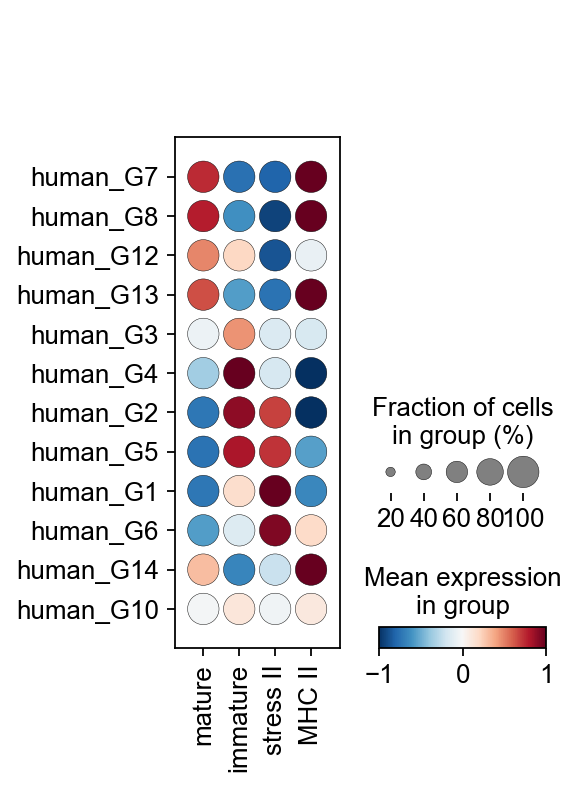

In [36]:
human_comb_alpha_g = sc.AnnData(human_comb_alpha.obs[obs_g])
human_comb_alpha_g.obs = human_comb_alpha.obs
sc.pl.dotplot(sc.pp.scale(human_comb_alpha_g, copy=True), groupby='louvain_anno_fine', 
              var_names=human_comb_alpha_g.var_names, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')

In [37]:
pig_comb_alpha_g = sc.AnnData(pig_comb_alpha.obs[obs_g])
pig_comb_alpha_g.obs = pig_comb_alpha.obs

In [38]:
mouse_comb_alpha_g = sc.AnnData(mouse_comb_alpha.obs[obs_g])
mouse_comb_alpha_g.obs = mouse_comb_alpha.obs

In [39]:
human_comb_alpha_g_scaled = sc.pp.scale(human_comb_alpha_g, copy=True)
pig_comb_alpha_g_scaled = sc.pp.scale(pig_comb_alpha_g, copy=True)
mouse_comb_alpha_g_scaled = sc.pp.scale(mouse_comb_alpha_g, copy=True)

In [40]:
human_comb_alpha_g_scaled.uns['louvain_anno_fine_colors']=['#fdb462', '#80b1d3', '#bebada', '#fb8072', '#8dd3c7']
pig_comb_alpha_g_scaled.uns['louvain_anno_fine_colors'] = ['#fdb462', '#80b1d3', '#bebada', '#fb8072', '#b15928']
mouse_comb_alpha_g_scaled.uns['louvain_anno_fine_colors'] = ['#fdb462', '#80b1d3', '#bebada', '#fb8072']

In [41]:
sc.pp.pca(human_comb_alpha_g_scaled)
sc.pp.neighbors(human_comb_alpha_g_scaled)
sc.tl.umap(human_comb_alpha_g_scaled)

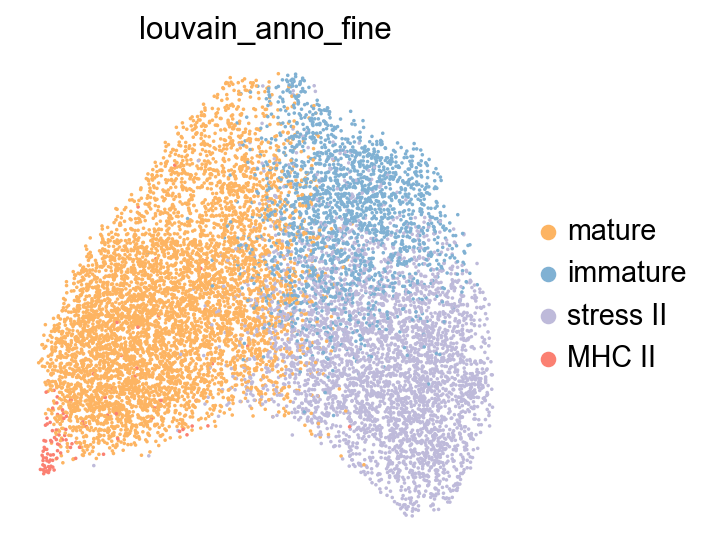

In [42]:
sc.set_figure_params(frameon=False)
sc.pl.umap(human_comb_alpha_g_scaled, color='louvain_anno_fine')

In [43]:
sc.tl.ingest(pig_comb_alpha_g_scaled, human_comb_alpha_g_scaled , obs='louvain_anno_fine', neighbors_key='neighbors')

In [44]:
sc.tl.ingest(mouse_comb_alpha_g_scaled, human_comb_alpha_g_scaled , obs='louvain_anno_fine', neighbors_key='neighbors')

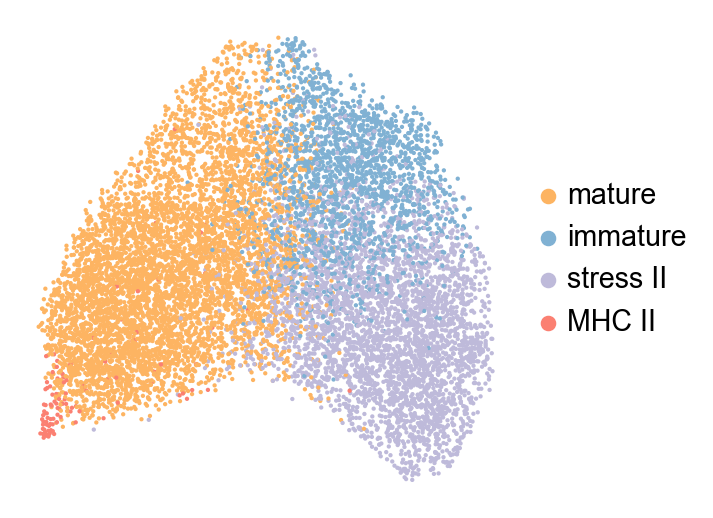

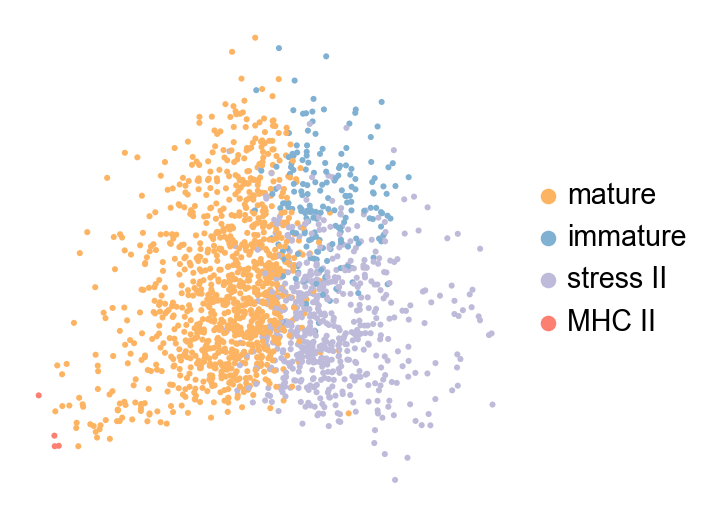

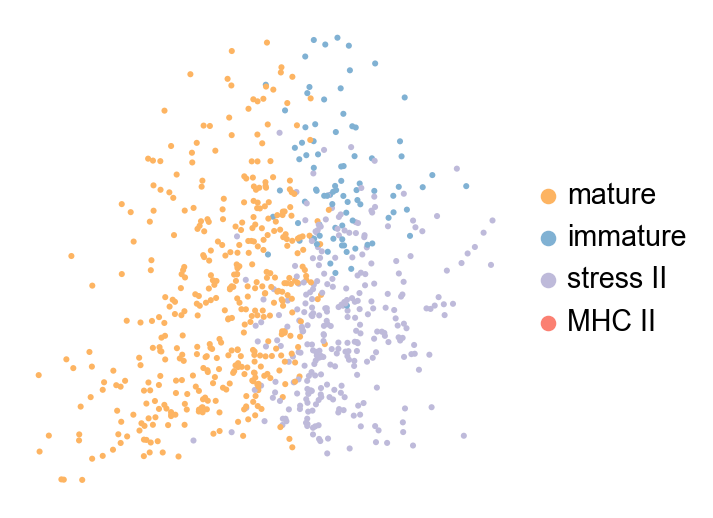

In [45]:
sc.pl.umap(human_comb_alpha_g_scaled, color='louvain_anno_fine', size=15, title='')
sc.pl.umap(pig_comb_alpha_g_scaled, color=['louvain_anno_fine'], size=30, title='')
sc.pl.umap(mouse_comb_alpha_g_scaled, color=['louvain_anno_fine'], size=30, title='')

findfont: Font family ['Helvetica Light'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Light'] not found. Falling back to DejaVu Sans.


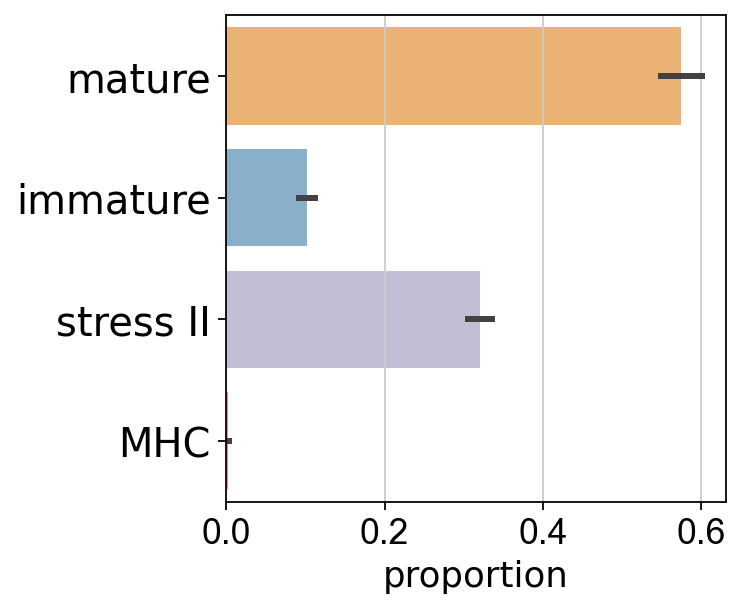

In [46]:
x1='louvain_anno_fine'
hue='donor'
y='proportion'
df = pd.crosstab(pig_comb_alpha_g_scaled.obs[x1], pig_comb_alpha_g_scaled.obs[hue], normalize=1)
df.index = df.index.tolist()
df.columns = df.columns.tolist()
prop_df = df.reset_index().melt(id_vars=['index'])

pl.subplots()

ax = sns.barplot(y='index', x='value', data=prop_df,palette = pig_comb_alpha_g_scaled.uns['louvain_anno_fine_colors'], orient='h')
ax.set_yticklabels(['mature', 'immature', 'stress II', 'MHC'])
pl.xticks(rotation=0,fontsize=16)
pl.yticks(rotation=0,fontsize=18,fontname='Helvetica Light')

pl.ylabel('')
pl.xlabel('proportion',fontsize=16,fontname='Helvetica Light')
pl.show()

In [47]:
prop_df

index variable     value
0     mature       01  0.549744
1   immature       01  0.111795
2  stress II       01  0.335385
3     MHC II       01  0.003077
4     mature       02  0.600912
5   immature       02  0.092360
6  stress II       02  0.305587
7     MHC II       02  0.001140

In [48]:
mouse_comb_alpha_g_scaled.obs['louvain_anno_fine'].cat.remove_unused_categories(inplace=True)

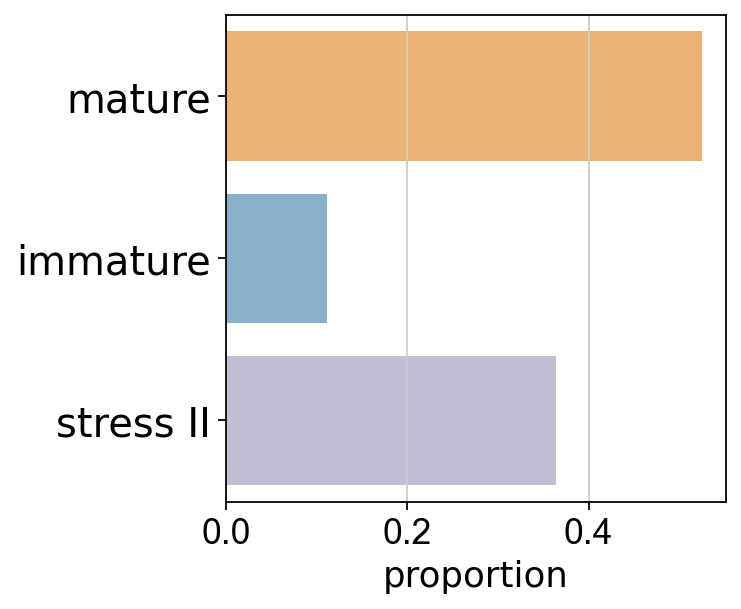

In [49]:
df=mouse_comb_alpha_g_scaled.obs[['louvain_anno_fine']]

pl.subplots()
x='louvain_anno_fine'
y='proportion'
prop_df = (df[x]
            .value_counts(normalize=True)
            .rename(y)
            .reset_index())

sns.barplot(x='proportion', y='index', data=prop_df,palette=pig_comb_alpha_g_scaled.uns['louvain_anno_fine_colors'],orient='h')
pl.xticks(rotation=0,fontsize=16)
pl.yticks(rotation=0,fontsize=18,fontname='Helvetica Light')

pl.ylabel('')
pl.xlabel('proportion',fontsize=16,fontname='Helvetica Light')
pl.show()

In [220]:
human_comb_alpha_g_scaled_sub = human_comb_alpha_g_scaled[np.invert(human_comb_alpha_g_scaled.obs.louvain_anno_fine.isin(['MHC II']))].copy()
pig_comb_alpha_g_scaled_sub = pig_comb_alpha_g_scaled[np.invert(pig_comb_alpha_g_scaled.obs.louvain_anno_fine.isin(['MHC II']))].copy()

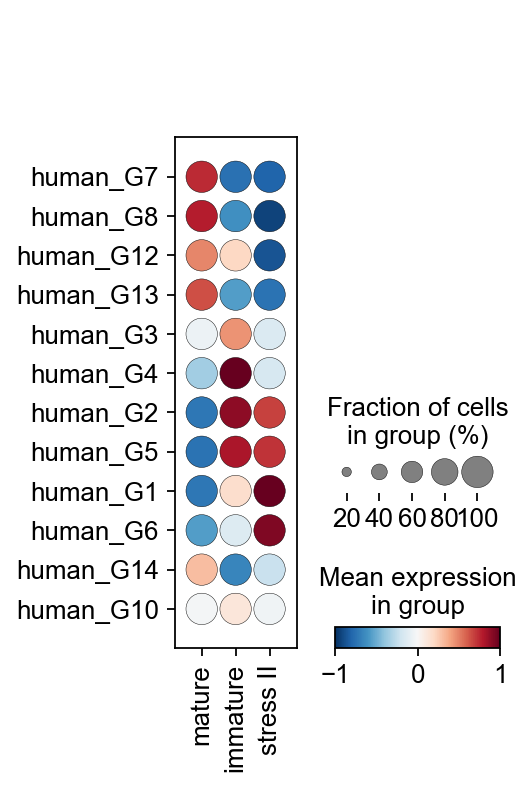

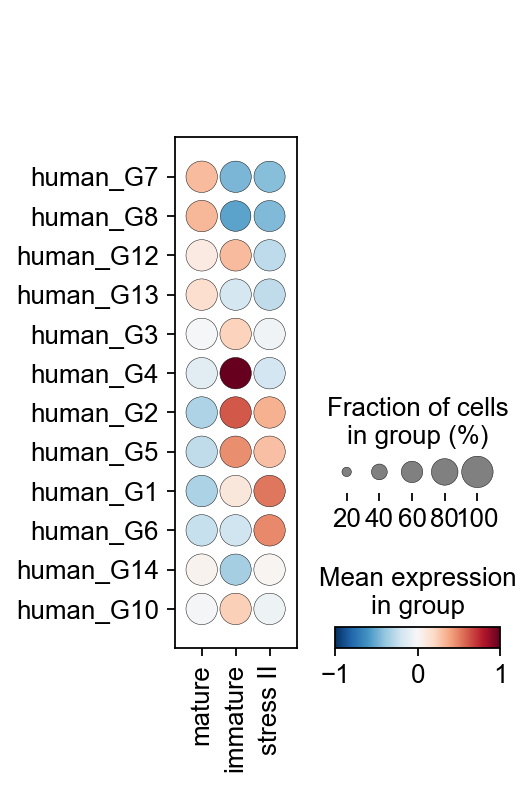

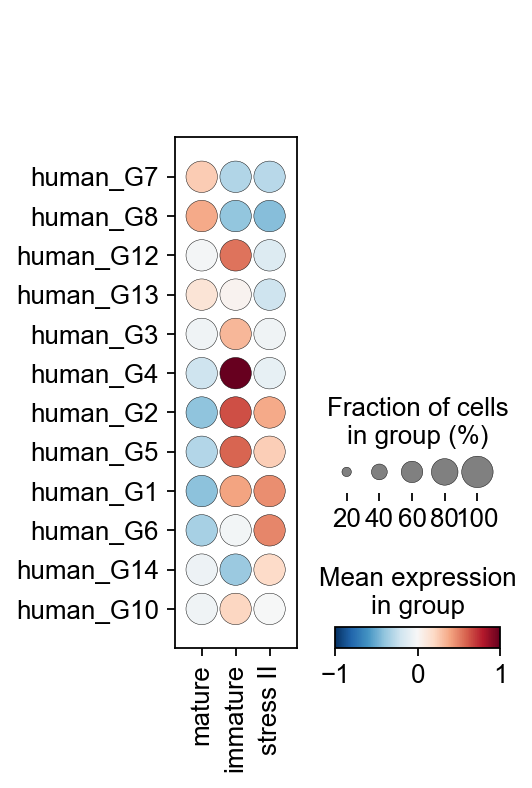

In [221]:
sc.pl.dotplot(human_comb_alpha_g_scaled_sub, groupby='louvain_anno_fine', 
              var_names=obs_g, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')
sc.pl.dotplot(pig_comb_alpha_g_scaled_sub, groupby='louvain_anno_fine', 
              var_names=obs_g, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')
sc.pl.dotplot(mouse_comb_alpha_g_scaled, groupby='louvain_anno_fine', 
              var_names=obs_g, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')

In [106]:
pig_comb_alpha.obs['louvain_anno_fine'] = pig_comb_alpha_g_scaled.obs['louvain_anno_fine']
mouse_comb_alpha.obs['louvain_anno_fine'] = mouse_comb_alpha_g_scaled.obs['louvain_anno_fine']

In [107]:
pig_comb_alpha.obsm['X_umap'] = pig_comb_alpha_g_scaled.obsm['X_umap']
mouse_comb_alpha.obsm['X_umap'] = mouse_comb_alpha_g_scaled.obsm['X_umap']

In [108]:
pig_comb_alpha = pig_comb_alpha[np.invert(pig_comb_alpha.obs.louvain_anno_fine.isin(['MHC II']))].copy()

### Selected marker gene expression

#### Identity genes

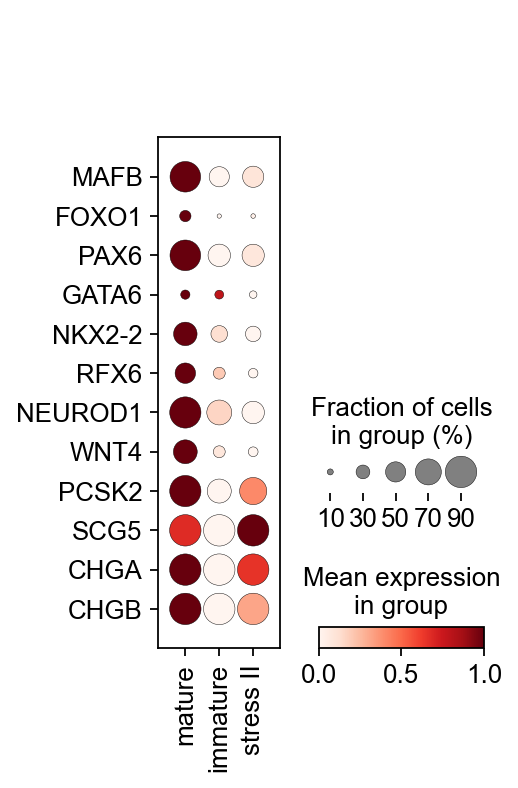

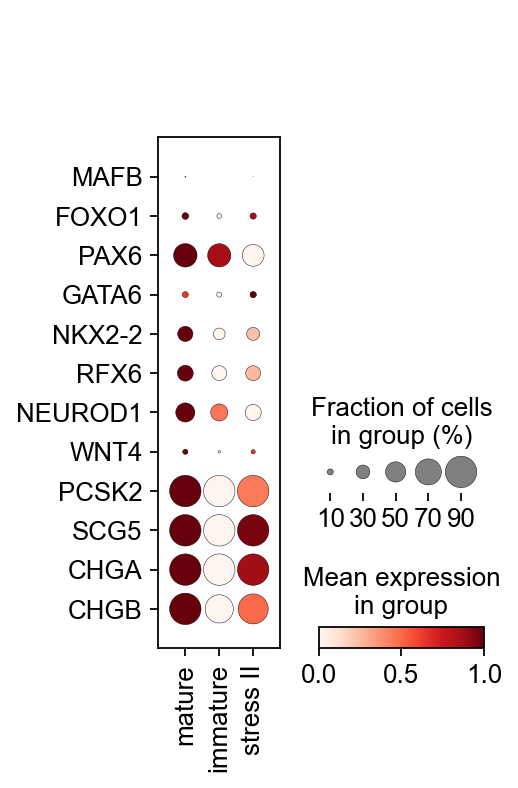

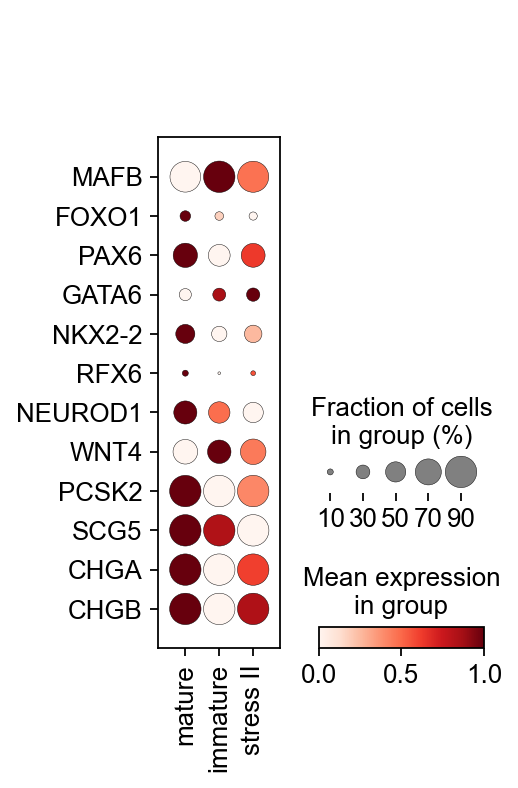

In [230]:
genes = ['MAFB', 'FOXO1', 'PAX6', 'GATA6', 'NKX2-2', 'RFX6', 'NEUROD1', 'WNT4', 'PCSK2', 'SCG5', 'CHGA', 'CHGB']
sc.pl.dotplot(human_comb_alpha_sub, groupby='louvain_anno_fine', var_names = genes, standard_scale='var', 
              var_group_rotation=0, dot_max=0.9, swap_axes=True)
sc.pl.dotplot(pig_comb_alpha, groupby='louvain_anno_fine', var_names = genes,
              standard_scale='var', var_group_rotation=0, dot_max=0.9, swap_axes=True)
sc.pl.dotplot(mouse_comb_alpha, groupby='louvain_anno_fine', var_names = genes, 
              standard_scale='var', var_group_rotation=0, dot_max=0.9, swap_axes=True)

#### Immaturity genes

In [231]:
gc_dict = {'developmental\nfactors': ['SOX4', 'NRG1', 'EPHB2',  'EPHB6', 'SPOCK1'],
            'growth factors/\nhormones': ['VEGFC', 'IGF2BP2', 'NPY'],
            'TGFB\nsignaling': ['TGFBR1', 'TGFBR2', 'TGFB1', 'SMAD3', 'SMAD5', 'SMAD7', 'SMAD9', 'SOCS3', 'ID1', 'ID2', 'ID3', 'TNC', 'MET', 'BMP2'],
            'other markers': ['SGK1', 'PHLDA1', 'PHLDA2'],}

In [232]:
genes = []
for k,v in gc_dict.items():
    genes = genes + v

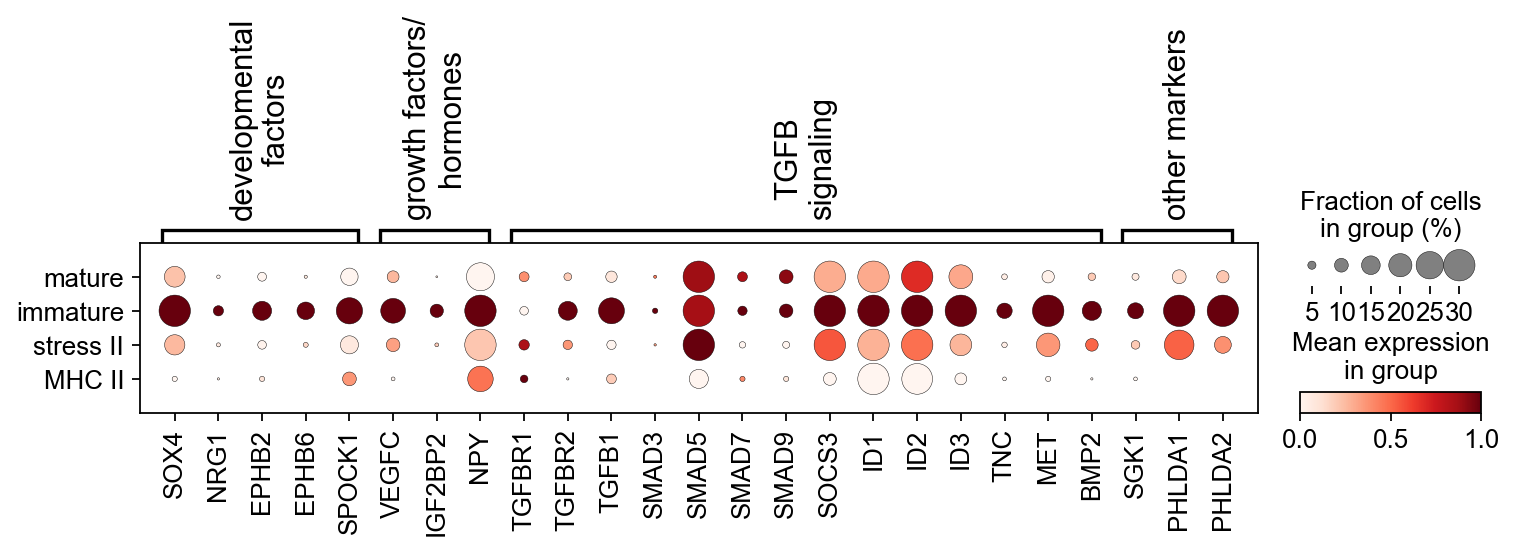

In [233]:
sc.pl.dotplot(human_comb_alpha, groupby='louvain_anno_fine', var_names = gc_dict, standard_scale='var', var_group_rotation=90, dot_max=0.3)

In [544]:
gc_dict = {'developmental\nfactors': ['SOX4', 'NRG1', 'EPHB2',  'EPHB6', 'SPOCK1'],
            'growth factors/\nhormones': ['VEGFC', 'IGF2BP2', 'NPY'],
            'TGFB\nsignaling': ['TGFBR1', 'TGFBR2', 'TGFB1', 'TGFB2', 'TGFB3', 'SMAD3', 'SMAD5', 'SMAD7', 'SMAD9', 'SOCS3', 'ID1', 'ID2', 'ID3', 'TNC', 'MET', 'BMP2'], 
                      'cell adhesion': ['ITGA2', 'ITGA6', 'ITGB6', 'LAMA3', 'LAMB3', 'LAMC1', 'LAMC2', 'FLRT2'],
           'cytokines': ['LIF', 'LIFR'],
           'interferone response': ['IFIT3', 'GBP2'],
}

In [545]:
genes = []
for k,v in gc_dict.items():
    genes = genes + v

In [546]:
human_comb_alpha_sub = human_comb_alpha[np.invert(human_comb_alpha.obs.louvain_anno_fine.isin(['MHC II']))].copy()

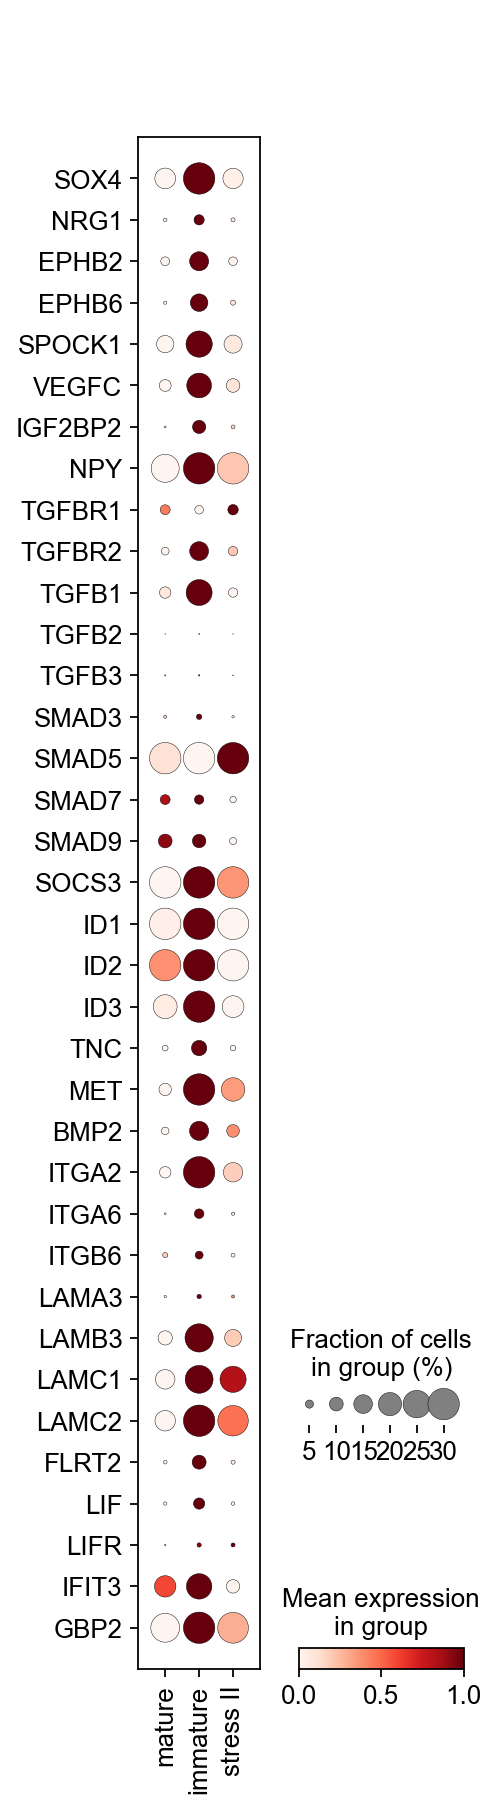

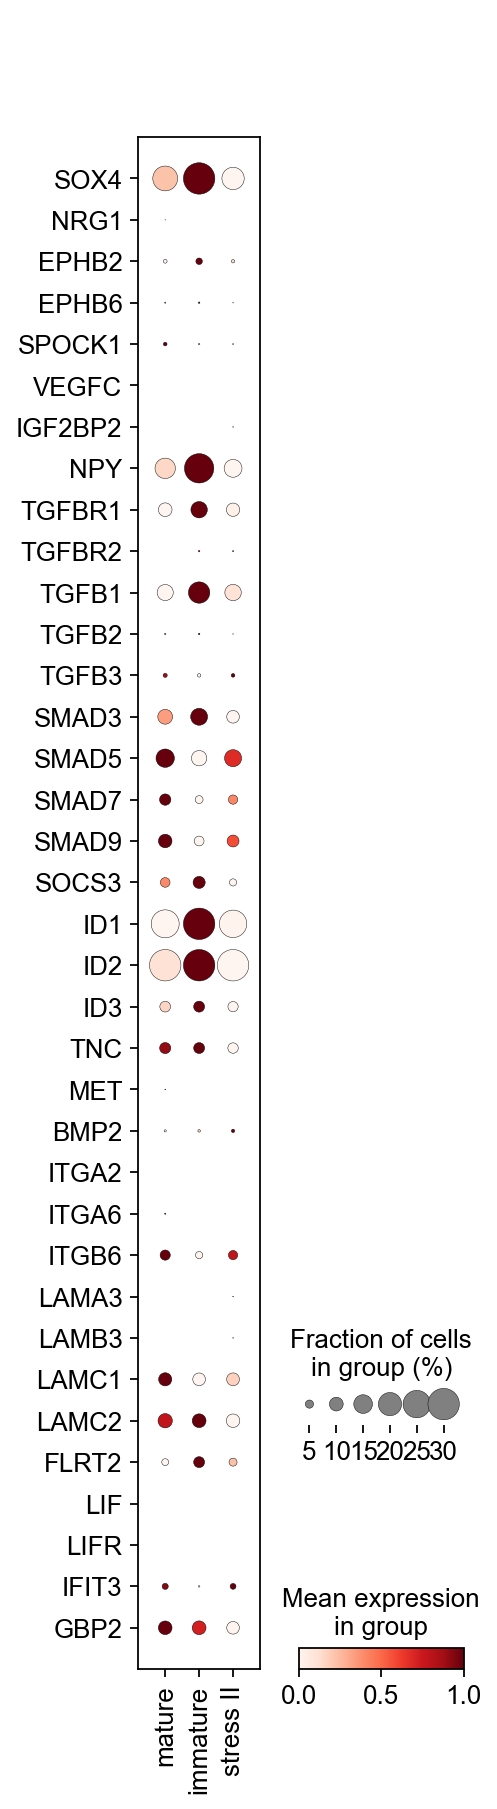

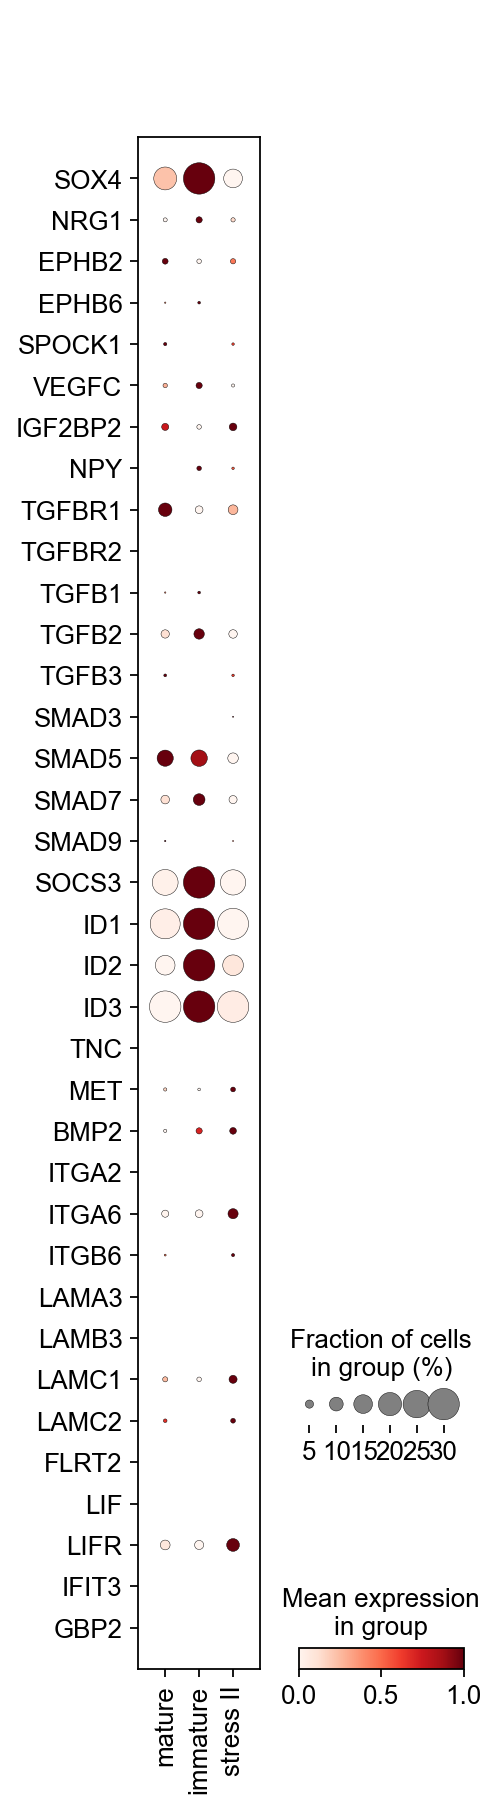

In [547]:
sc.pl.dotplot(human_comb_alpha_sub, groupby='louvain_anno_fine', var_names = genes, standard_scale='var', 
              var_group_rotation=0, dot_max=0.3, swap_axes=True)
sc.pl.dotplot(pig_comb_alpha, groupby='louvain_anno_fine', var_names = genes,
              standard_scale='var', var_group_rotation=0, dot_max=0.3, swap_axes=True)
sc.pl.dotplot(mouse_comb_alpha, groupby='louvain_anno_fine', var_names = genes, 
              standard_scale='var', var_group_rotation=0, dot_max=0.3, swap_axes=True)

#### Stress response genes

In [539]:
stress_dict = {'IRE': ['ERN1','TRAF2','MAP3K5'],
              'PERK': ['EIF2AK3','EIF2A','ATF4','DDIT3','PPP1R15A','PPP1CC'],
              'ATF6': ['ATF6','XBP1','HSPA5'], 
              'ATF3': ['ATF3'], 
              'ERAD': ['HERPUD1', 'SDF2L1', 'DERL2', 'SYVN1', 'EDEM1']}

In [540]:
stress_genes = []
for k,v in stress_dict.items():
    stress_genes = stress_genes+v

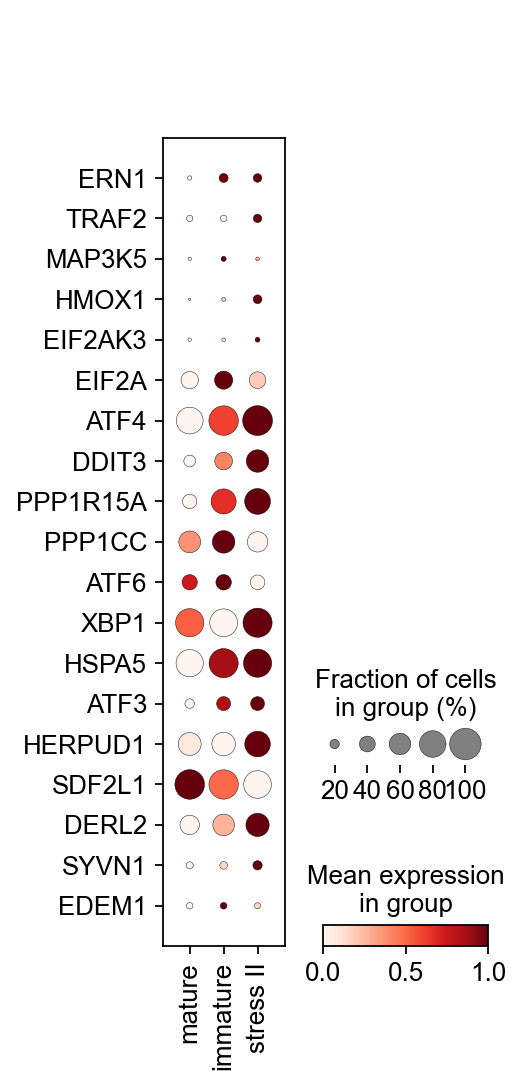

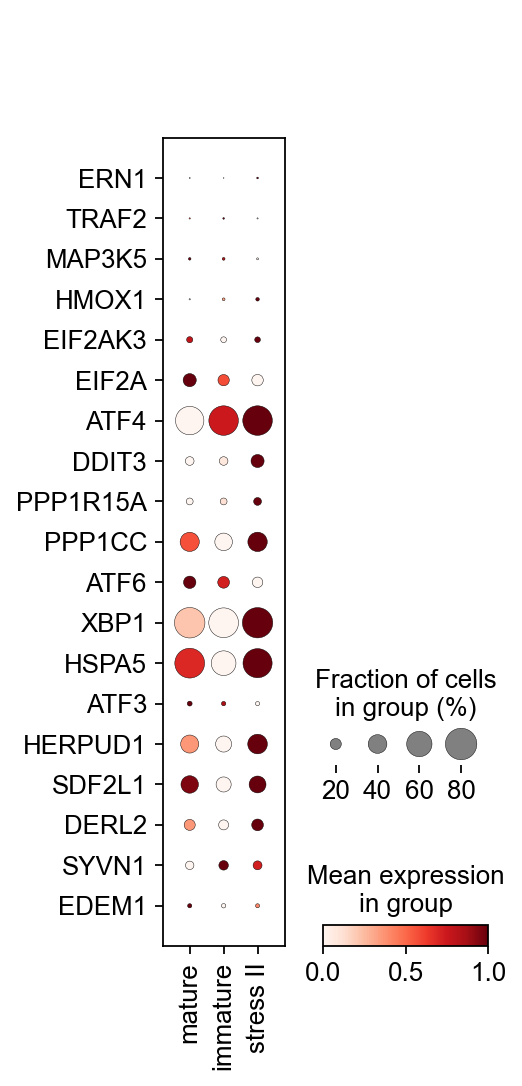

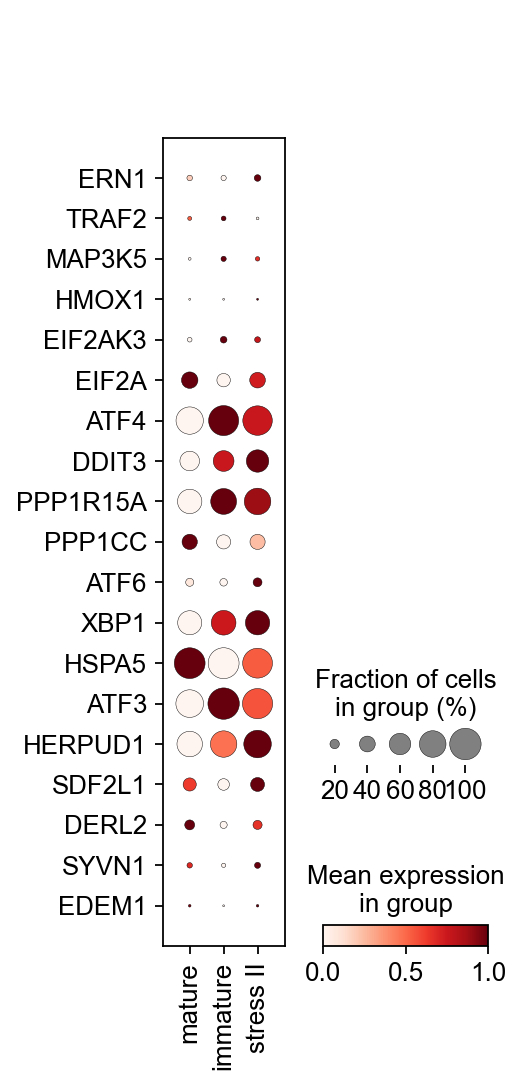

In [541]:
sc.pl.dotplot(human_comb_alpha_sub, groupby='louvain_anno_fine', var_names = stress_genes, standard_scale='var', 
              swap_axes=True)
sc.pl.dotplot(pig_comb_alpha, groupby='louvain_anno_fine', var_names = stress_genes,
              standard_scale='var', swap_axes=True)
sc.pl.dotplot(mouse_comb_alpha, groupby='louvain_anno_fine', var_names = stress_genes, 
              standard_scale='var', swap_axes=True)

### Correlation of alpha cell subtypes in PC space

In [440]:
adata_comb_alpha = sc.pp.scale(human_comb_alpha, copy=True).concatenate(sc.pp.scale(pig_comb_alpha, copy=True), sc.pp.scale(mouse_comb_alpha, copy=True), batch_categories=['human', 'pig', 'mouse'])

In [441]:
sc.pp.highly_variable_genes(adata_comb_alpha, n_top_genes=4000, flavor='cell_ranger')
sc.pp.pca(adata_comb_alpha)

In [488]:
adata_comb_alpha.obs['louvain_species'] = ['_'.join([a,b]) for a,b in zip(adata_comb_alpha.obs.batch, adata_comb_alpha.obs.louvain_anno_fine)]

In [446]:
%%time
genedf = sc.get.obs_df(
        adata_comb_alpha,
        keys=['louvain_species'],
        obsm_keys=[('X_pca', i) for i in range(0,50)] #if i not in [1]]
    )
grouped = genedf.groupby('louvain_species')
mean_df = grouped.mean()

CPU times: user 26.5 ms, sys: 10.5 ms, total: 37.1 ms
Wall time: 43.2 ms


In [447]:
df_corr = mean_df.T.corr(method='pearson')

In [467]:
human_comb_alpha.uns['louvain_anno_fine_colors']

array(['#fdb462', '#80b1d3', '#bebada', '#fb8072'], dtype=object)

In [449]:
adata_comb_alpha.obs['louvain_anno_fine'] = adata_comb_alpha.obs['louvain_anno_fine'].astype('category')

In [470]:
adata_comb_alpha.obs['louvain_anno_fine'].cat.reorder_categories(['mature', 'immature', 'stress II', 'MHC II'], inplace=True)

In [473]:
adata_comb_alpha.obs['batch'].cat.reorder_categories(['human', 'pig', 'mouse'], inplace=True)

#### clustering and heatmap

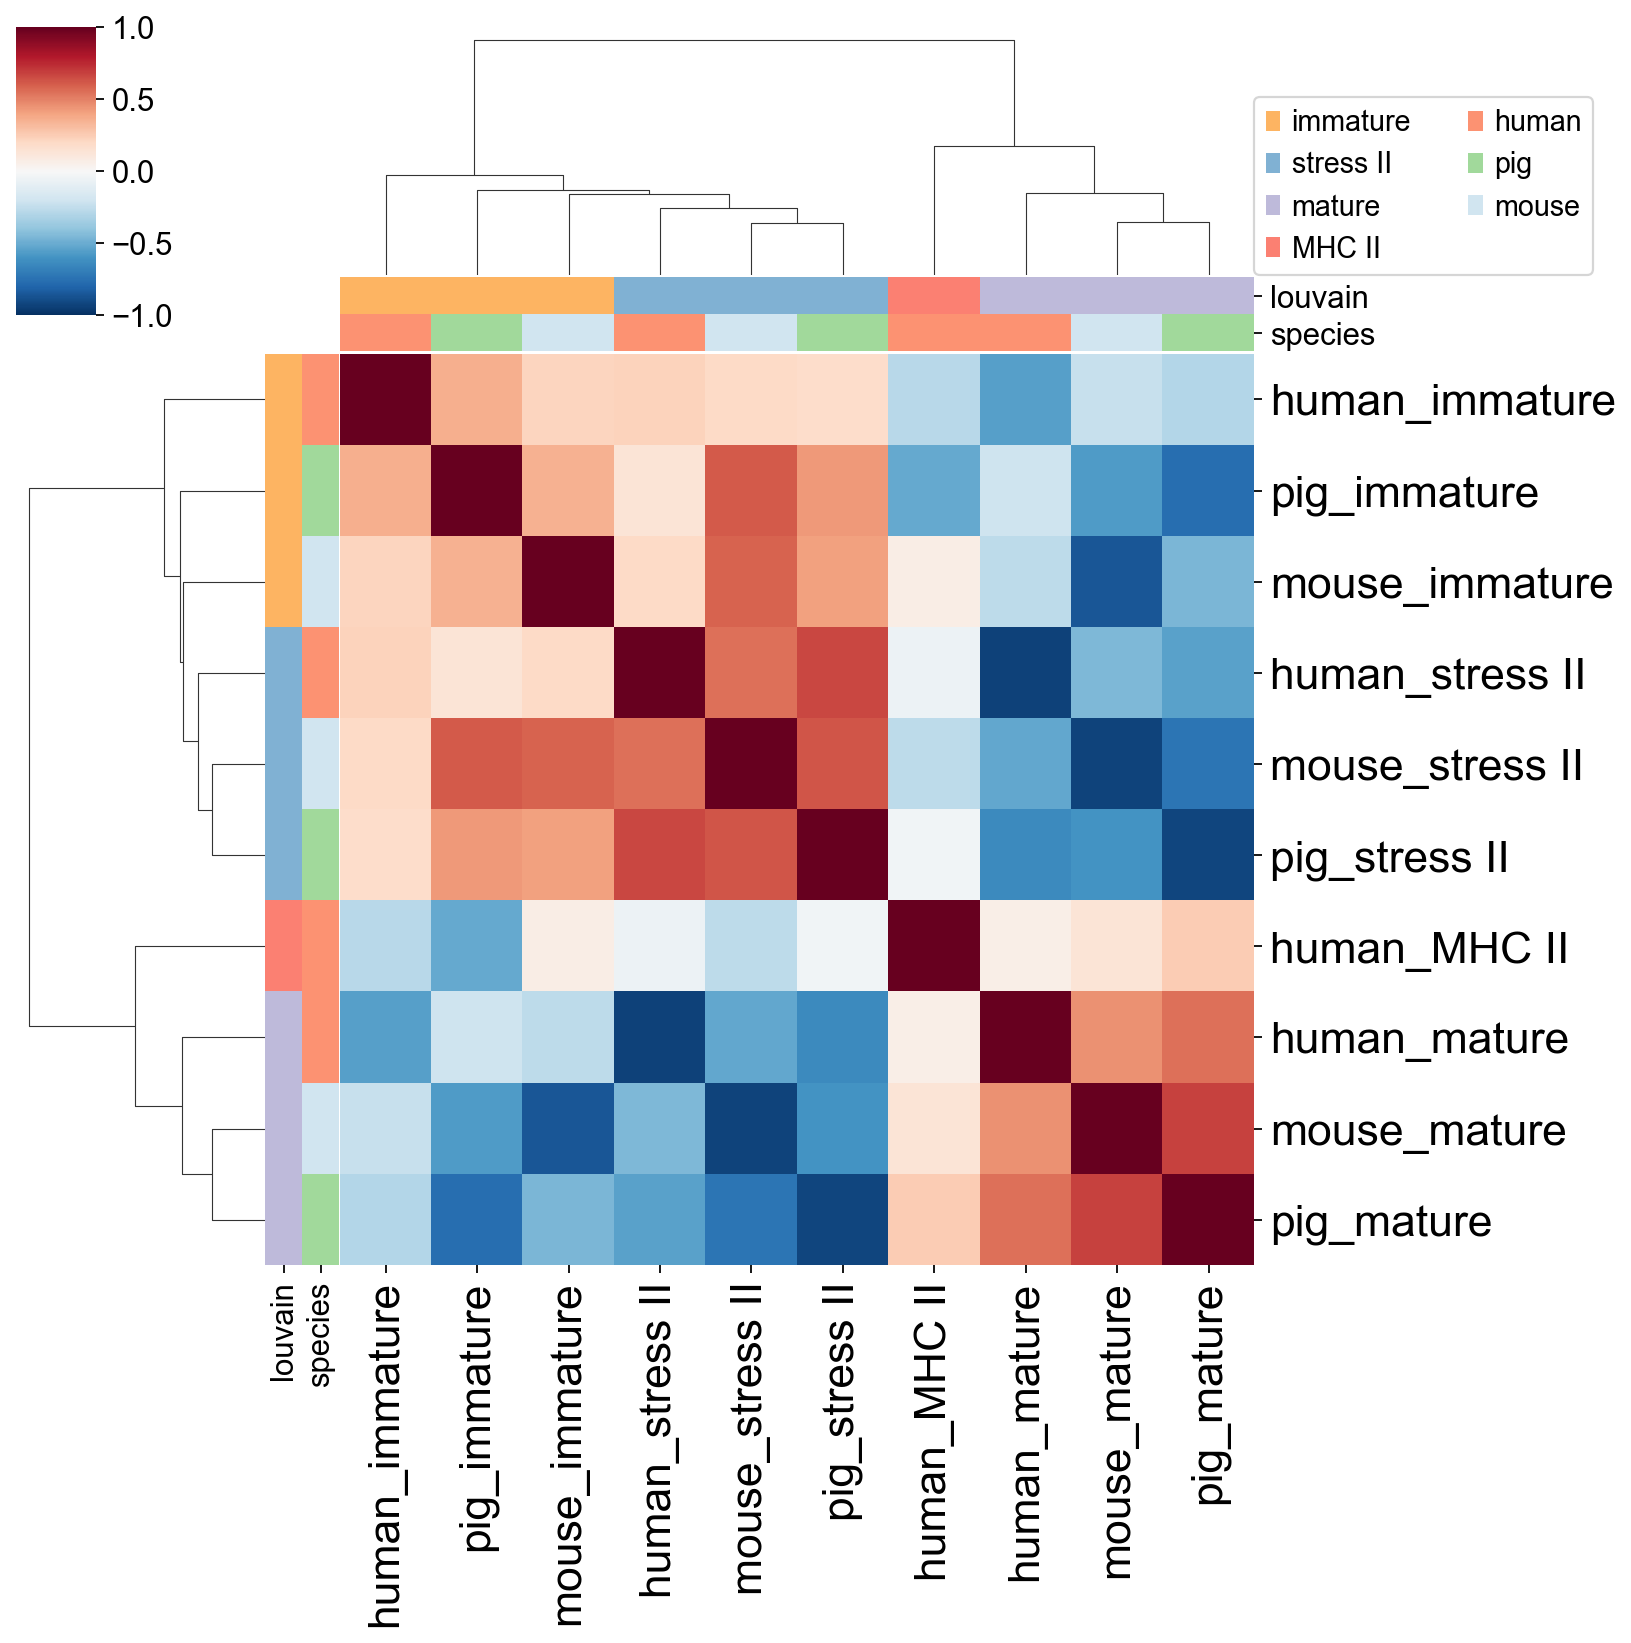

In [520]:
cols = pd.DataFrame(index = df_corr.index)
col_dict_1 = dict(zip(set(adata_comb_alpha.obs.louvain_anno_fine.cat.categories), ['#fdb462', '#80b1d3', '#bebada', '#fb8072']))
cols['louvain'] = pd.DataFrame([g.split('_',1)[1] for g in mean_df.index], index=df_corr.index)[0].map(col_dict_1)
col_dict_2 = dict(zip(set(adata_comb_alpha.obs.batch.cat.categories), ['#fc9272', '#a1d99b',  '#d1e5f0']))
cols['species'] = pd.DataFrame([g.split('_')[0] for g in mean_df.index], index=df_corr.index)[0].map(col_dict_2)




g = sns.clustermap(df_corr,
               col_colors=cols,row_colors=cols, vmin=-1,vmax=1,
               cmap='RdBu_r')

for label in col_dict_1.keys():
    g.ax_col_dendrogram.bar(0, 0, color=col_dict_1[label],
                           label=label, linewidth=0)
for label in col_dict_2.keys():
    g.ax_col_dendrogram.bar(0, 0, color=col_dict_2[label],
                            label=label, linewidth=0)
    
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20)
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')

g.ax_col_dendrogram.legend(loc=(1,0), ncol=2)

#### graph representation

In [489]:
sc.pp.neighbors(adata_comb_alpha)
sc.tl.paga(adata_comb_alpha, groups='louvain_species')

... storing 'louvain_species' as categorical


In [490]:
from scipy.sparse import csr_matrix

In [491]:
adata_comb_alpha.uns['paga']['connectivities'] = csr_matrix(df_corr.to_numpy().copy())

In [492]:
adata_comb_alpha.uns['paga']['connectivities_low_thr'] = csr_matrix(df_corr.to_numpy()+0.1)

In [493]:
pos = np.array([[ 1.62191405,  1.52937668],
       [ 1.23332803,  1.009166 ],
       [ 0.07928282,  1.48927375],
       [-0.2287415, -2.88148255],#h
       [- 0.24961311, -0.50232758],#m
       [-1.0590353, -2.26346964],#p
       [-2.62506038, -1.43752191],#h
       [-2.58476716, -0.2336543 ],
       [-3.2529614 , -0.68265099],
       [ 3.34791657, -1.03029484],#h
       [ 2.51190543, -0.50126031],
       [ 2.51983171, -1.55057058],
       [ 0.85409415, -2.26346964],#h
       [-1.745026  , -0.93045428],
       [-0.0287415 , -1.63648541],
       [-0.24350365,  0.58598068],#h
       [-1.47740348,  0.02772971],
       [ 1.24261767,  0.02772971]])

In [494]:
human_comb_alpha_g_scaled.uns['louvain_anno_fine_colors']

['#fdb462', '#80b1d3', '#bebada', '#fb8072', '#8dd3c7']

In [495]:
adata_comb_alpha.obs.louvain_species.cat.categories

Index(['human_MHC II', 'human_immature', 'human_mature', 'human_stress II',
       'mouse_immature', 'mouse_mature', 'mouse_stress II', 'pig_immature',
       'pig_mature', 'pig_stress II'],
      dtype='object')

In [498]:
adata_comb_alpha.uns['louvain_species_colors'] = ['#fb8072', '#80b1d3', '#fdb462', '#bebada', 
                                                  '#80b1d3', '#fdb462', '#bebada', '#80b1d3', '#fdb462', '#bebada']

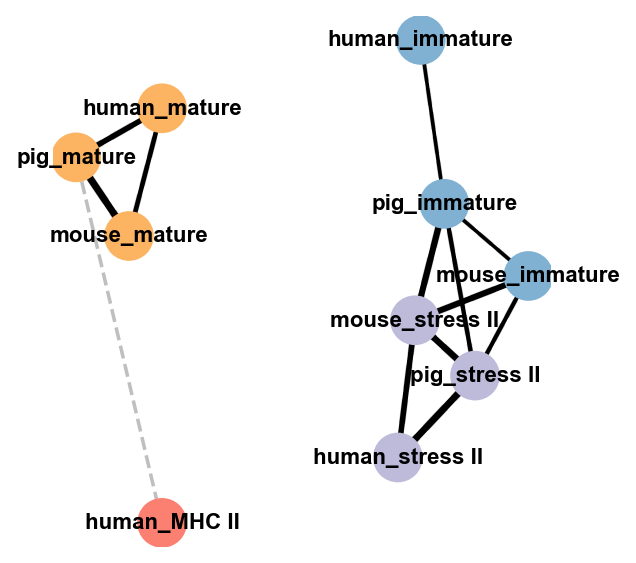

In [501]:
sc.pl.paga(adata_comb_alpha, threshold=0.35, edge_width_scale=0.6, fontsize=10, dashed_edges='connectivities_low_thr',
        node_size_power=0, node_size_scale=3)
 
          

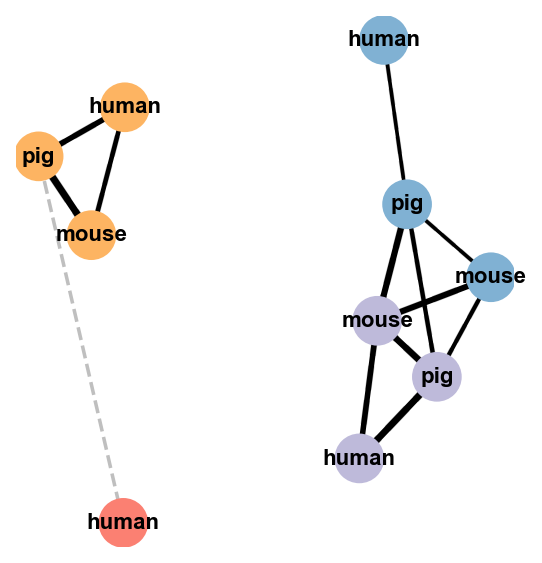

In [500]:
sc.pl.paga(adata_comb_alpha, threshold=0.35, edge_width_scale=0.6, fontsize=10, dashed_edges='connectivities_low_thr',
        node_size_power=0, node_size_scale=3, labels=['human', 'human', 'human', 'human', 'mouse',  'mouse',  'mouse', 'pig', 'pig', 'pig'])
 
          

### Conservation of gene set expression/

In [240]:
mk_human = pd.read_excel('./output_files/gene_sets_alpha.xlsx')
gene_sets_map = {}
for col in mk_human.columns:
    gene_sets_map[f'G{col}'] = [gene for gene in mk_human[col] if gene in conv.human_symbol.tolist()]

In [241]:
gs_dict = {'mature': ['G7', 'G8', 'G12', 'G13'],
           'immature': ['G3', 'G4', 'G2', 'G5'],
           'stress II': ['G1',  'G6']}

In [242]:
gene_sets_louvain = {}
for key in gs_dict.keys():
    genes = []
    for gs in gs_dict[key]:
        genes = genes + gene_sets_map[gs]
        
    gene_sets_louvain[key] = genes

In [243]:
tfs = pd.read_csv('./data/TF_names_v_1.01_human.txt',sep='\t',header=None).unstack().tolist()

In [244]:
gene_sets_tf = {}
for key in gene_sets_map.keys():
    gene_sets_tf[key] = [tf for tf in gene_sets_map[key] if tf in tfs]

In [245]:
gene_sets_tf_louvain = {}

for key in gs_dict.keys():
    tfs = []
    for gs in gs_dict[key]:
        tfs = tfs + gene_sets_tf[gs]
        
    gene_sets_tf_louvain[key]=tfs

In [579]:
expression_dict_beta_species={}

df = pd.DataFrame(index=human_comb_alpha_sub.var_names, columns=human_comb_alpha_sub.obs.louvain_anno_fine.cat.categories)
for key in human_comb_alpha_sub.obs.louvain_anno_fine.cat.categories:
    human_sub = human_comb_alpha_sub[human_comb_alpha_sub.obs.louvain_anno_fine.isin([key])].copy()
    genes = (human_sub.X > 0).sum(0) / human_sub.n_obs
    df[key] = genes.A1
expression_dict_beta_species['human'] = df

df = pd.DataFrame(index=pig_comb_alpha.var_names, columns=pig_comb_alpha.obs.louvain_anno_fine.cat.categories)
for key in pig_comb_alpha.obs.louvain_anno_fine.cat.categories:
    pig_sub = pig_comb_alpha[pig_comb_alpha.obs.louvain_anno_fine.isin([key])].copy()
    genes = (pig_sub.X > 0).sum(0) / pig_sub.n_obs
    df[key] = genes.A1
expression_dict_beta_species['pig'] = df 

df = pd.DataFrame(index=mouse_comb_alpha.var_names, columns=mouse_comb_alpha.obs.louvain_anno_fine.cat.categories)
for key in mouse_comb_alpha.obs.louvain_anno_fine.cat.categories:
    mouse_sub = mouse_comb_alpha[mouse_comb_alpha.obs.louvain_anno_fine.isin([key])].copy()
    genes = (mouse_sub.X > 0).sum(0) / mouse_sub.n_obs
    df[key] = genes.A1
expression_dict_beta_species['mouse'] = df

In [128]:
tfs_mapped = [tf for tf in tfs if tf in human_comb_alpha_sub.var_names]

In [248]:
gene_set_conservation_dict = {}

for key in ['mature', 'immature', 'stress II']:

    genes_human = gene_sets_louvain[key]
    df = pd.DataFrame(index=genes_human, columns=['mouse', 'pig'])  
    
    
    detected = expression_dict_beta_species['pig']>0.05
    detected = detected.index[detected.any(axis=1)].tolist()
    
    detected_key = expression_dict_beta_species['pig']>0.05
    detected_key = detected_key.index[detected_key[key]].tolist()
    
    df['pig'] = ['conserved' if gene in detected_key else
                 'loss' if gene in detected else
                 'not detected' for gene in genes_human]
    
    detected = expression_dict_beta_species['mouse']>0.05
    detected = detected.index[detected.any(axis=1)].tolist()
    
    detected_key = expression_dict_beta_species['mouse']>0.05
    detected_key = detected_key.index[detected_key[key]].tolist()
    
    df['mouse'] = ['conserved' if gene in detected_key else
                   'loss' if gene in detected else
                   'not detected' for gene in genes_human]
    
    gene_set_conservation_dict[key]=df

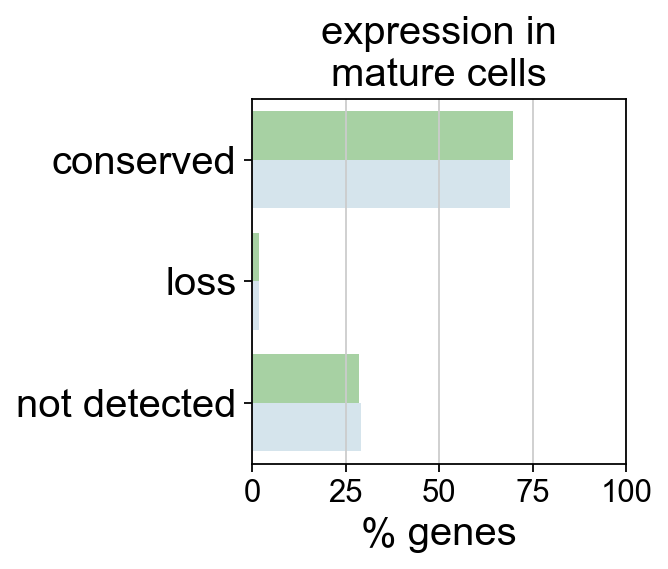

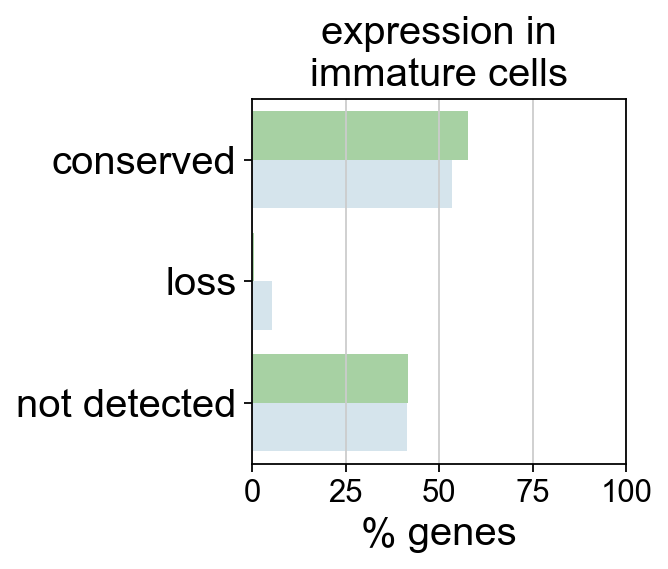

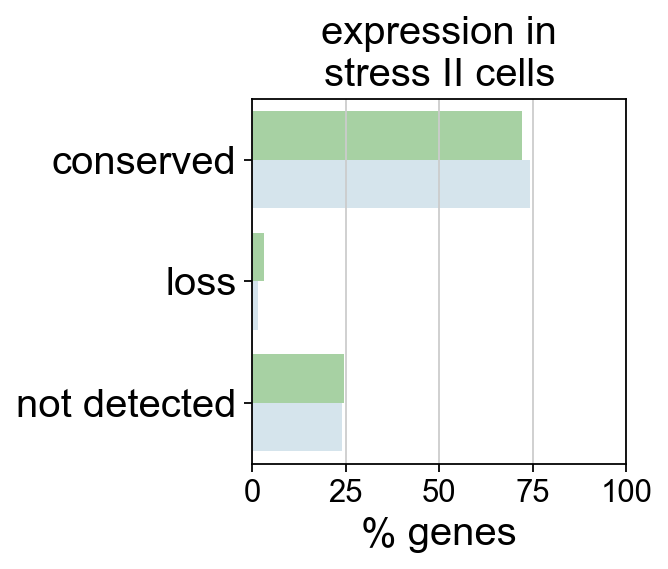

In [249]:
for key in ['mature', 'immature', 'stress II']:
    df_bar = gene_set_conservation_dict[key][['pig', 'mouse']].melt()

    f, ax = pl.subplots(figsize=(3, 3))
    y='% genes'
    prop_df = (df_bar['value']
                        .groupby(df_bar['variable'])
                        .value_counts(normalize=True)
                        .rename(y)
                        .reset_index())
    prop_df[y] = prop_df[y]*100

    sns.barplot(x=y, y="value", data=prop_df, hue='variable', order=['conserved', 'loss', 'not detected'], hue_order=['pig', 'mouse'], palette=['#a1d99b','#d1e5f0'])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    ax.legend().remove()
    pl.ylabel('')
    pl.xlabel('% genes', fontsize=18)
    pl.xlim([0,100])
    pl.title(f'expression in\n{key} cells', fontsize=18)

## Annotation of alpha and beta cell subpopulations in endocrine manifolds

In [566]:
human_comb.obs['louvain_anno'] = ['_'.join(['beta', x]) for x in human_comb.obs.louvain_anno_fine]
human_comb_alpha.obs['louvain_anno'] = ['_'.join(['alpha', x]) for x in human_comb_alpha.obs.louvain_anno_fine]

In [567]:
human_comb_endo.obs['louvain_anno_fine'] = human_comb_endo.obs['louvain_anno_broad'].copy().tolist()

In [568]:
human_comb_endo.obs['louvain_anno_fine'].loc[human_comb.obs_names] = human_comb.obs['louvain_anno']
human_comb_endo.obs['louvain_anno_fine'].loc[human_comb_alpha.obs_names] = human_comb_alpha.obs['louvain_anno']

In [569]:
human_comb_endo.write('./human_endo_mapped.h5ad')

... storing 'louvain_anno_fine' as categorical


In [570]:
pig_comb.obs['louvain_anno'] = ['_'.join(['beta', x]) for x in pig_comb.obs.louvain_anno_fine]
pig_comb_alpha.obs['louvain_anno'] = ['_'.join(['alpha', x]) for x in pig_comb_alpha.obs.louvain_anno_fine]

In [571]:
pig_comb_endo.obs['louvain_anno_fine'] = pig_comb_endo.obs['louvain_anno_broad'].copy().tolist()

In [572]:
pig_comb_endo.obs['louvain_anno_fine'].loc[pig_comb.obs_names] = pig_comb.obs['louvain_anno']
pig_comb_endo.obs['louvain_anno_fine'].loc[pig_comb_alpha.obs_names] = pig_comb_alpha.obs['louvain_anno']

In [573]:
pig_comb_endo.write('./pig_endo_mapped.h5ad')

... storing 'louvain_anno_fine' as categorical


In [574]:
mouse_comb.obs['louvain_anno'] = ['_'.join(['beta', x]) for x in mouse_comb.obs.louvain_anno_fine]
mouse_comb_alpha.obs['louvain_anno'] = ['_'.join(['alpha', x]) for x in mouse_comb_alpha.obs.louvain_anno_fine]

In [575]:
mouse_comb_endo.obs['louvain_anno_fine'] = mouse_comb_endo.obs['louvain_anno_broad'].copy().tolist()

In [576]:
mouse_comb_endo.obs['louvain_anno_fine'].loc[mouse_comb.obs_names] = mouse_comb.obs['louvain_anno']
mouse_comb_endo.obs['louvain_anno_fine'].loc[mouse_comb_alpha.obs_names] = mouse_comb_alpha.obs['louvain_anno']

In [577]:
mouse_comb_endo.write('./mouse_endo_mapped.h5ad')

... storing 'louvain_anno_fine' as categorical
